In [31]:

# --- IMPORTS ---

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import copy
import pickle
import glob
import tqdm
import requests
import time
# --- CONFIGURACIÓN DE DISPOSITIVO ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {DEVICE}")

# Crear carpetas necesarias
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

✅ Usando dispositivo: cuda


In [50]:
# --- CLASES AUXILIARES ---
class TSP_Instance:
    def __init__(self, city_locations):
        self.city_locations = city_locations
        self.num_cities = len(city_locations)
        # Matriz de distancias Euclidianas
        diff = city_locations[:, np.newaxis, :] - city_locations[np.newaxis, :, :]
        self.distance_matrix = np.sqrt(np.sum(diff ** 2, axis=-1))

class TSP_State:
    def __init__(self, instance):
        self.instance = instance
        self.visited = [False] * instance.num_cities
        self.tour = [0] # Siempre empezamos en la ciudad 0
        self.visited[0] = True
        self.cost = 0.0
        self.current_city = 0

    def visit_city(self, city_idx):
        if not self.visited[city_idx]:
            dist = self.instance.distance_matrix[self.current_city][city_idx]
            self.cost += dist
            self.current_city = city_idx
            self.tour.append(city_idx)
            self.visited[city_idx] = True

# --- SOLUCIONADOR OR-TOOLS (El Maestro) ---
def solve_ortools(instance):
    # Configurar datos para OR-Tools
    # Escalamos las distancias (float -> int) porque OR-Tools trabaja mejor con enteros
    scale = 10000
    dist_matrix = (instance.distance_matrix * scale).astype(int).tolist()

    manager = pywrapcp.RoutingIndexManager(instance.num_cities, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return dist_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    solution = routing.SolveWithParameters(search_parameters)

    # Extraer solución
    route = []
    if solution:
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        # No añadimos el nodo final (que es volver al 0) para simplificar el entrenamiento
    return route


#Generar Data

In [58]:

# --- GENERADOR DE DATASET ---
def generate_dataset(num_samples=10000, num_cities=20, filename="tsp_data.pkl"):
    print(f"🚀 Generando {num_samples} problemas de {num_cities} ciudades...")

    X_src = []   # Coordenadas
    visited = [] # Historial parcial
    Y = []       # Siguiente ciudad correcta (Target)

    for i in range(num_samples):
        # 1. Crear ciudades aleatorias
        locs = np.random.rand(num_cities, 2)
        instance = TSP_Instance(locs)

        # 2. Resolver con OR-Tools
        optimal_tour = solve_ortools(instance)

        # 3. Crear ejemplos de entrenamiento paso a paso
        # "Si he visitado [0, 5, 2], la siguiente correcta es 8"
        current_tour = [0] # Empezamos en 0

        # Recorremos la solución óptima para generar los pasos
        # optimal_tour ej: [0, 5, 2, 8, 1...]
        for target_city in optimal_tour[1:]: # Empezamos desde el segundo
            # Input: Coordenadas
            X_src.append(locs)

            # Input: Ciudades visitadas hasta ahora (con padding -1 si fuera necesario,
            # pero aquí aplanamos el dataset así que usamos listas fijas o padding luego)
            # Para simplificar y ahorrar memoria, guardaremos el estado actual como lista
            # y luego en el DataLoader haremos el padding.

            # Aquí tu compañero usó una estrategia de Padding directo:
            visit_pad = np.array(current_tour)
            visit_pad = np.pad(visit_pad, (0, num_cities - len(visit_pad)), 'constant', constant_values=-1)
            visited.append(visit_pad)

            # Output: One-Hot de la ciudad destino
            y_onehot = np.zeros(num_cities)
            y_onehot[target_city] = 1
            Y.append(y_onehot)

            # Avanzamos el estado
            current_tour.append(target_city)

        if (i+1) % 100 == 0: print(f"   Processed {i+1}/{num_samples}")

    # Guardar
    data = (np.array(X_src), np.array(visited), np.array(Y))
    with open(f"data/{filename}", "wb") as f:
        pickle.dump(data, f)
    print("✅ Dataset generado y guardado.")

# --- EJECUTAR GENERACIÓN ---
# Generamos un dataset pequeño para probar (puedes aumentar num_samples)
generate_dataset(num_samples=6000, num_cities=50, filename="tsp_train.pkl")

🚀 Generando 6000 problemas de 50 ciudades...
   Processed 100/6000
   Processed 200/6000
   Processed 300/6000
   Processed 400/6000
   Processed 500/6000
   Processed 600/6000
   Processed 700/6000
   Processed 800/6000
   Processed 900/6000
   Processed 1000/6000
   Processed 1100/6000
   Processed 1200/6000
   Processed 1300/6000
   Processed 1400/6000
   Processed 1500/6000
   Processed 1600/6000
   Processed 1700/6000
   Processed 1800/6000
   Processed 1900/6000
   Processed 2000/6000
   Processed 2100/6000
   Processed 2200/6000
   Processed 2300/6000
   Processed 2400/6000
   Processed 2500/6000
   Processed 2600/6000
   Processed 2700/6000
   Processed 2800/6000
   Processed 2900/6000
   Processed 3000/6000
   Processed 3100/6000
   Processed 3200/6000
   Processed 3300/6000
   Processed 3400/6000
   Processed 3500/6000
   Processed 3600/6000
   Processed 3700/6000
   Processed 3800/6000
   Processed 3900/6000
   Processed 4000/6000
   Processed 4100/6000
   Processed 4200/600

KeyboardInterrupt: 

#MODELO

In [52]:
class TSPTransformer(nn.Module):
    def __init__(self, input_dim=2, embed_dim=128, num_heads=8, num_layers=2, dropout_rate=0.1):
        super(TSPTransformer, self).__init__()
        self.embed_dim = embed_dim

        # --- ENCODER ---
        self.encoder_input_layer = nn.Linear(input_dim, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout_rate,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # --- DECODER ---
        self.ctx_fusion = nn.Linear(3 * embed_dim, embed_dim)

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True
        )

        self.pointer = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, x_src, visited):
        """
        x_src: [Batch, N, 2]
        visited: [Batch, N]
        """
        B, num_cities, _ = x_src.shape

        # 1. Encoder
        enc_input = self.encoder_input_layer(x_src)
        memory = self.encoder(enc_input)

        # 2. Máscaras
        valid_mask = (visited != -1)

        visited_city_mask = torch.zeros(B, num_cities, dtype=torch.bool, device=visited.device)
        batch_idx = torch.arange(B, device=visited.device).unsqueeze(1).expand_as(visited)

        batch_idx_flat = batch_idx[valid_mask]
        visited_flat = visited[valid_mask]

        # Corrección: Aseguramos que sea Long aquí también
        visited_city_mask[batch_idx_flat, visited_flat.long()] = True

        # 3. Contexto (Media)
        mask_expanded = visited_city_mask.unsqueeze(-1).float()
        sum_ctx = (memory * mask_expanded).sum(dim=1)
        count_ctx = mask_expanded.sum(dim=1).clamp(min=1)
        context_mean = sum_ctx / count_ctx

        # 4. Contexto (Start + Last)
        lengths = valid_mask.sum(dim=1) - 1

        # --- AQUÍ ESTABA EL ERROR ---
        start_node = visited[:, 0].long()
        # Agregamos .long() al final para convertir los índices decimales a enteros
        last_node = visited.gather(1, lengths.unsqueeze(1).long()).squeeze(1).long()

        # Extraemos embeddings de la memoria
        batch_range = torch.arange(B, device=visited.device)
        start_emb = memory[batch_range, start_node]
        last_emb = memory[batch_range, last_node] # Ahora esto funcionará

        # Fusión
        ctx_concat = torch.cat([context_mean, last_emb, start_emb], dim=-1)
        query = self.ctx_fusion(ctx_concat).unsqueeze(1)

        # 5. Cross Attention
        attn_out, _ = self.cross_attn(query, memory, memory)
        attn_out = attn_out.squeeze(1)

        # 6. Pointer & Masking
        ptr_query = self.pointer(attn_out).unsqueeze(1)
        scores = torch.matmul(ptr_query, memory.transpose(1, 2)).squeeze(1)

        scores = scores.masked_fill(visited_city_mask, float("-inf"))

        return scores

#Entrenamiento

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import os
import time
import math
import numpy as np # Necesario por si acaso

# 1. CONFIGURACIÓN DE DISPOSITIVO
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"✅ MODO TURBO ACTIVO: Usando {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device("cpu")
    print("⚠️ MODO TURBO DESACTIVADO: No se detectó GPU. Esto no será tan rápido.")

# 2. DEFINICIÓN DEL MODELO (Necesaria para que el script funcione)
class TSPTransformer(nn.Module):
    def __init__(self, input_dim=2, embed_dim=128, num_heads=8, num_layers=2, dropout_rate=0.1):
        super(TSPTransformer, self).__init__()
        self.encoder_input_layer = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout_rate, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ctx_fusion = nn.Linear(3 * embed_dim, embed_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout_rate, batch_first=True)
        self.pointer = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, x_src, visited):
        B, num_cities, _ = x_src.shape
        enc_input = self.encoder_input_layer(x_src)
        memory = self.encoder(enc_input)
        valid_mask = (visited != -1)
        visited_city_mask = torch.zeros(B, num_cities, dtype=torch.bool, device=visited.device)
        batch_idx = torch.arange(B, device=visited.device).unsqueeze(1).expand_as(visited)
        visited_city_mask[batch_idx[valid_mask], visited[valid_mask].long()] = True
        
        mask_expanded = visited_city_mask.unsqueeze(-1).float()
        sum_ctx = (memory * mask_expanded).sum(dim=1)
        count_ctx = mask_expanded.sum(dim=1).clamp(min=1)
        context_mean = sum_ctx / count_ctx
        
        lengths = valid_mask.sum(dim=1) - 1
        start_node = visited[:, 0].long()
        last_node = visited.gather(1, lengths.unsqueeze(1).long()).squeeze(1).long()
        
        batch_range = torch.arange(B, device=visited.device)
        start_emb = memory[batch_range, start_node]
        last_emb = memory[batch_range, last_node]
        
        ctx_concat = torch.cat([context_mean, last_emb, start_emb], dim=-1)
        query = self.ctx_fusion(ctx_concat).unsqueeze(1)
        attn_out, _ = self.cross_attn(query, memory, memory)
        ptr_query = self.pointer(attn_out.squeeze(1)).unsqueeze(1)
        scores = torch.matmul(ptr_query, memory.transpose(1, 2)).squeeze(1)
        scores = scores.masked_fill(visited_city_mask, float("-inf"))
        return scores

# 3. CONFIGURACIÓN DE ENTRENAMIENTO
BATCH_SIZE = 256  
EPOCHS = 100

# --- CARGA ULTRA RÁPIDA ---
def load_data_to_gpu(filename):
    file_path = os.path.join("data", filename)
    # Fallback por si data/ no existe
    if not os.path.exists(file_path):
        if os.path.exists(filename): file_path = filename
        else: 
            raise FileNotFoundError(f"❌ No encuentro: {file_path}. ¡Ejecuta el generador de datos primero!")

    print(f"📂 Cargando y enviando a GPU: {file_path}...")
    with open(file_path, "rb") as f:
        X, Visited, Y = pickle.load(f)

    # 1. Convertir y Mover a GPU DE UNA VEZ
    X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    
    # Normalizar en GPU
    max_val = X.max()
    if max_val > 1.0: X = X / max_val

    Visited = torch.tensor(Visited, dtype=torch.long).to(DEVICE)
    Y = torch.tensor(Y, dtype=torch.float32).to(DEVICE) 

    # Split manual (80/20) usando índices
    total = len(X)
    train_size = int(0.8 * total)
    
    # Índices aleatorios
    indices = torch.randperm(total).to(DEVICE)
    train_idx = indices[:train_size]
    val_idx = indices[train_size:]
    
    return (
        X[train_idx], Visited[train_idx], Y[train_idx],
        X[val_idx], Visited[val_idx], Y[val_idx]
    )

# --- ENTRENAMIENTO SIN DATALOADER (Loop Manual) ---
def train_model_turbo(epochs=50):
    # 1. Cargar todo a la VRAM
    train_x, train_vis, train_y, val_x, val_vis, val_y = load_data_to_gpu("tsp_train.pkl")
    
    n_train = len(train_x)
    n_val = len(val_x)
    print(f"🔥 Datos en VRAM: {n_train} train, {n_val} val.")

    model = TSPTransformer(num_layers=3, num_heads=8, embed_dim=128).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    criterion = nn.CrossEntropyLoss()

    print(f"🚀 Iniciando entrenamiento TURBO...")
    start_total = time.time()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        start_epoch = time.time()
        
        # Shuffle manual de índices para el batching
        indices = torch.randperm(n_train, device=DEVICE)
        
        # Bucle de Batches Manual
        for i in range(0, n_train, BATCH_SIZE):
            idx = indices[i : i + BATCH_SIZE]
            bx, bvis, by = train_x[idx], train_vis[idx], train_y[idx]
            
            optimizer.zero_grad()
            logits = model(bx, bvis)
            target = by.argmax(dim=1) 
            
            loss = criterion(logits, target)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for i in range(0, n_val, BATCH_SIZE):
                bx = val_x[i : i + BATCH_SIZE]
                bvis = val_vis[i : i + BATCH_SIZE]
                by = val_y[i : i + BATCH_SIZE]
                
                logits = model(bx, bvis)
                target = by.argmax(dim=1)
                
                val_loss += criterion(logits, target).item()
                correct += (logits.argmax(dim=1) == target).sum().item()

        # Métricas
        num_train_batches = math.ceil(n_train / BATCH_SIZE)
        num_val_batches = math.ceil(n_val / BATCH_SIZE)
        
        avg_train_loss = train_loss / num_train_batches
        avg_val_loss = val_loss / num_val_batches
        acc = (correct / n_val) * 100
        
        scheduler.step(avg_val_loss)
        
        # TIEMPO
        dt = time.time() - start_epoch
        print(f"Ep {epoch+1}/{epochs} | ⏱️ {dt:.2f}s | Loss: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | Acc: {acc:.2f}%")

        if (epoch + 1) % 20 == 0:
            torch.save(model.state_dict(), f"models/tsp_ep{epoch+1}.pth")

    torch.save(model.state_dict(), "models/tsp_transformer.pth")
    print(f"🏁 Total: {(time.time()-start_total)/60:.1f} min.")
    return model

if __name__ == "__main__":
    # Asegúrate de haber generado los datos antes con generate_dataset()
    if os.path.exists("data/tsp_train.pkl"):
        trained_model = train_model_turbo(epochs=20)
    else:
        print("❌ ERROR: No encuentro data/tsp_train.pkl. Ejecuta el generador de datos primero.")

✅ MODO TURBO ACTIVO: Usando NVIDIA GeForce RTX 3050 Laptop GPU
📂 Cargando y enviando a GPU: data\tsp_train.pkl...
🔥 Datos en VRAM: 91200 train, 22800 val.
🚀 Iniciando entrenamiento TURBO...
Ep 1/20 | ⏱️ 16.55s | Loss: 2.0794 | Val: 2.0684 | Acc: 26.75%
Ep 2/20 | ⏱️ 16.49s | Loss: 2.0742 | Val: 2.0684 | Acc: 27.11%
Ep 3/20 | ⏱️ 16.81s | Loss: 2.0738 | Val: 2.0684 | Acc: 26.11%
Ep 4/20 | ⏱️ 16.70s | Loss: 2.0736 | Val: 2.0682 | Acc: 26.34%
Ep 5/20 | ⏱️ 16.61s | Loss: 2.0730 | Val: 2.0684 | Acc: 24.39%
Ep 6/20 | ⏱️ 16.91s | Loss: 2.0731 | Val: 2.0685 | Acc: 26.67%
Ep 7/20 | ⏱️ 16.55s | Loss: 1.4179 | Val: 0.5556 | Acc: 83.00%
Ep 8/20 | ⏱️ 16.37s | Loss: 0.5369 | Val: 0.4481 | Acc: 86.34%
Ep 9/20 | ⏱️ 16.50s | Loss: 0.4892 | Val: 0.4178 | Acc: 86.96%
Ep 10/20 | ⏱️ 16.41s | Loss: 0.4670 | Val: 0.4046 | Acc: 87.52%
Ep 11/20 | ⏱️ 16.55s | Loss: 0.4500 | Val: 0.3988 | Acc: 87.30%
Ep 12/20 | ⏱️ 16.39s | Loss: 0.4344 | Val: 0.3884 | Acc: 87.29%
Ep 13/20 | ⏱️ 16.67s | Loss: 0.4261 | Val: 0.3855 |

#Validacion con datos generados aleatoriamente


In [ ]:
def calculate_tour_length(dist_matrix, tour):
    """Calcula la distancia total del tour usando la matriz de distancias."""
    cost = 0.0
    for i in range(len(tour) - 1):
        u, v = tour[i], tour[i+1]
        cost += dist_matrix[u][v]
    # Regreso al inicio
    cost += dist_matrix[tour[-1]][tour[0]]
    return cost

def plot_tour(ax, points, tour, cost, title, color='b'):
    """Grafica la ruta encontrada."""
    # Cerrar el ciclo para el dibujo
    tour_closed = np.append(tour, tour[0])
    path = points[tour_closed]

    ax.plot(path[:, 0], path[:, 1], linestyle='-', marker='o', color=color, alpha=0.6, markersize=3)
    ax.scatter(path[0, 0], path[0, 1], c='red', s=40, zorder=10) # Inicio
    ax.set_title(f"{title}\nCosto: {cost:.4f}", fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

🚀 Generando 2000 casos (N=50)...
🧠 Ejecutando Beam Search (k=3) en GPU...
⚡ IA terminó en 33.77s
⏳ Evaluando resultados...


  0%|          | 0/2000 [00:00<?, ?it/s]

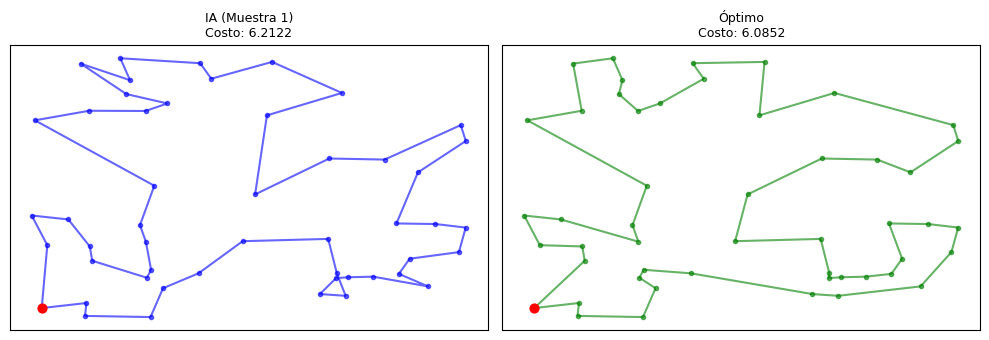

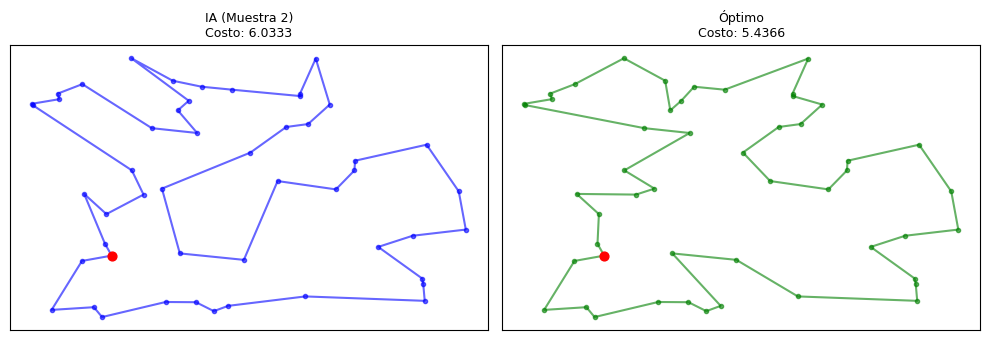

  0%|          | 2/2000 [00:00<03:17, 10.09it/s]

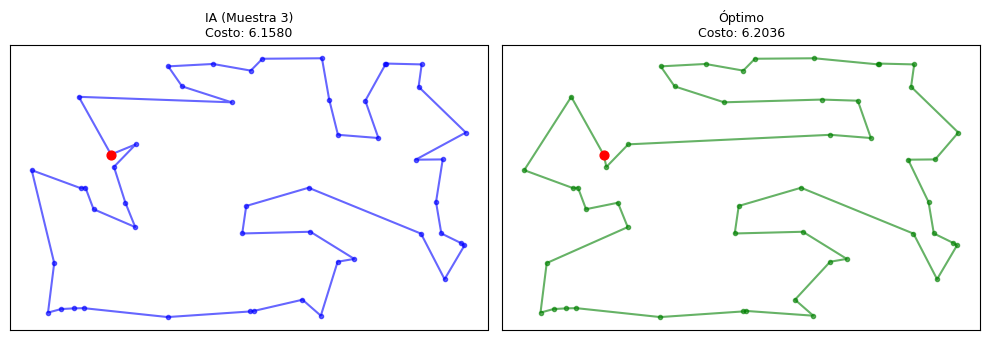

  0%|          | 10/2000 [00:00<01:34, 21.00it/s]C:\Users\intix\AppData\Local\Temp\ipykernel_41856\795474452.py:143: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


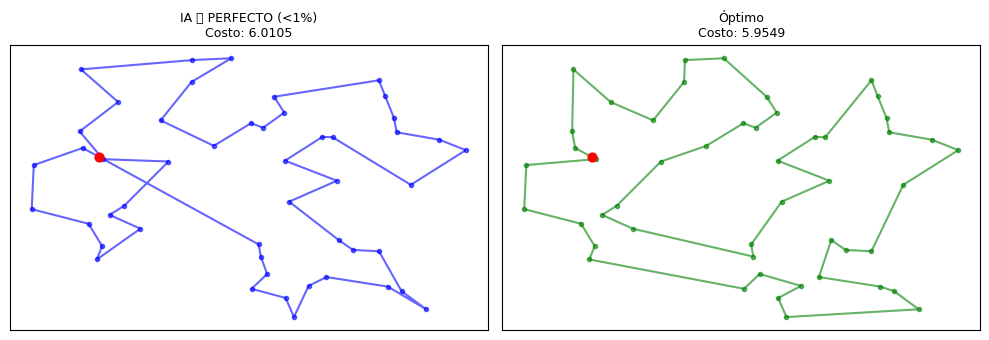

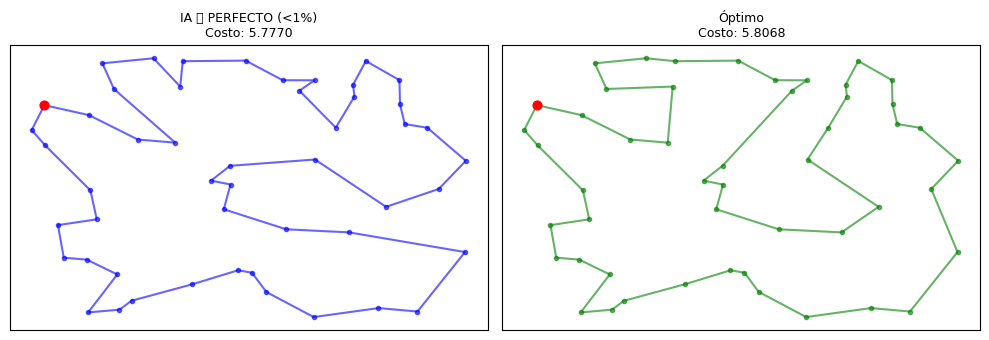

  1%|          | 13/2000 [00:00<01:51, 17.88it/s]

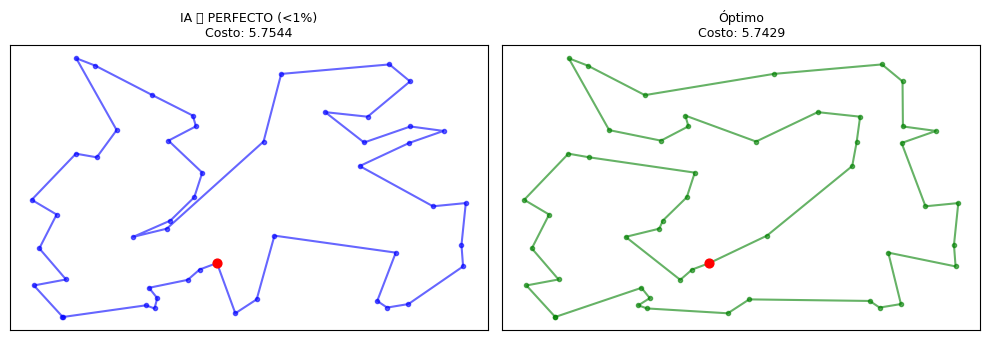

  1%|          | 22/2000 [00:01<01:20, 24.48it/s]

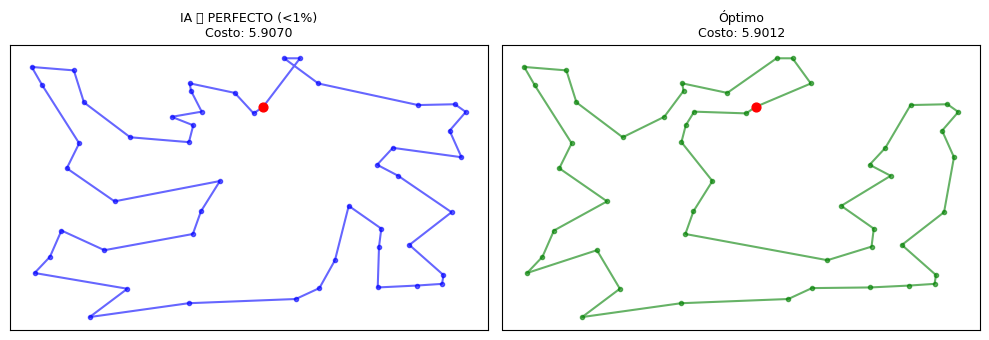

  1%|▏         | 25/2000 [00:01<01:32, 21.43it/s]

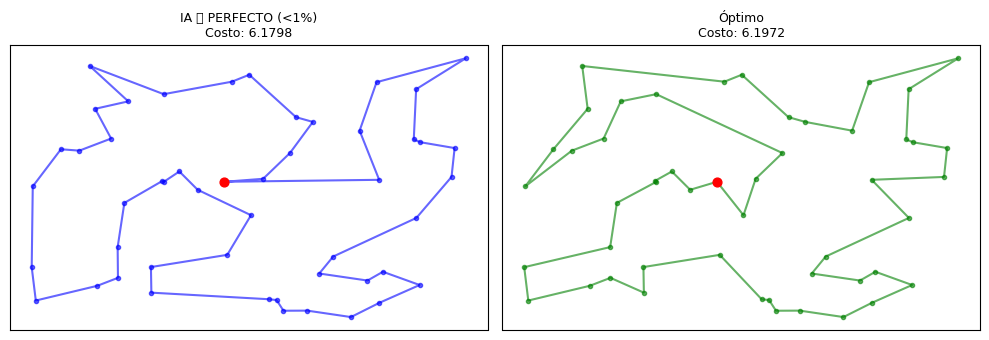

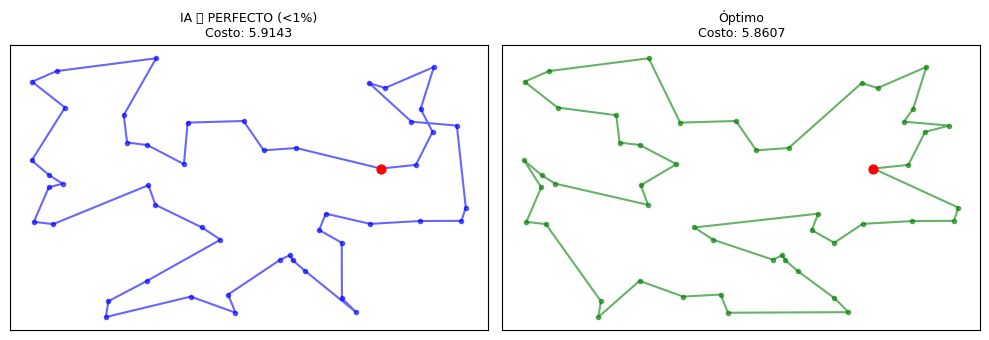

  3%|▎         | 52/2000 [00:02<01:10, 27.75it/s]

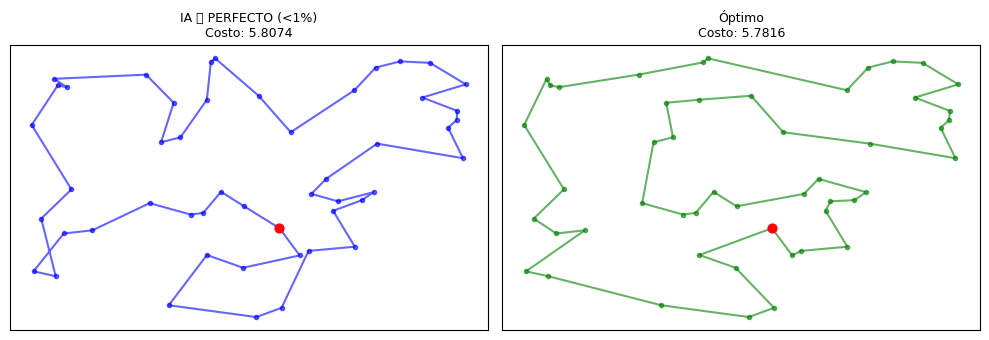

  3%|▎         | 55/2000 [00:02<01:17, 24.99it/s]

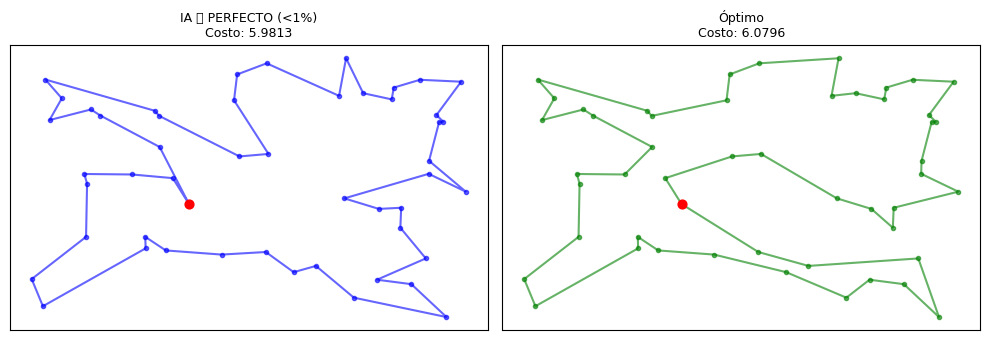

  5%|▍         | 95/2000 [00:03<01:03, 30.08it/s]

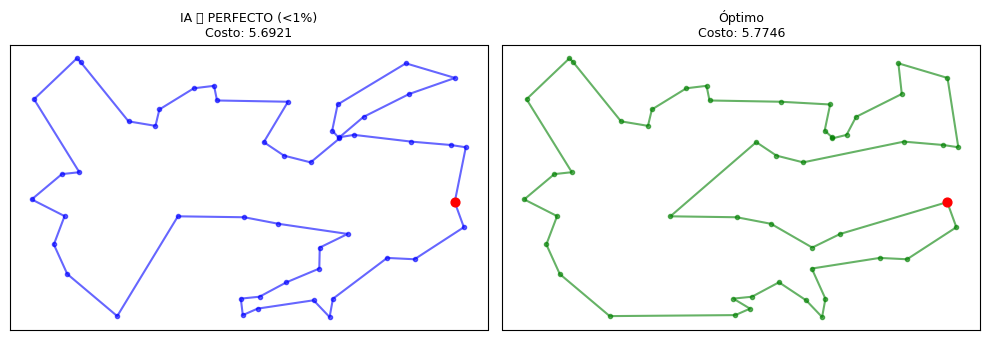

  5%|▍         | 99/2000 [00:04<01:18, 24.33it/s]

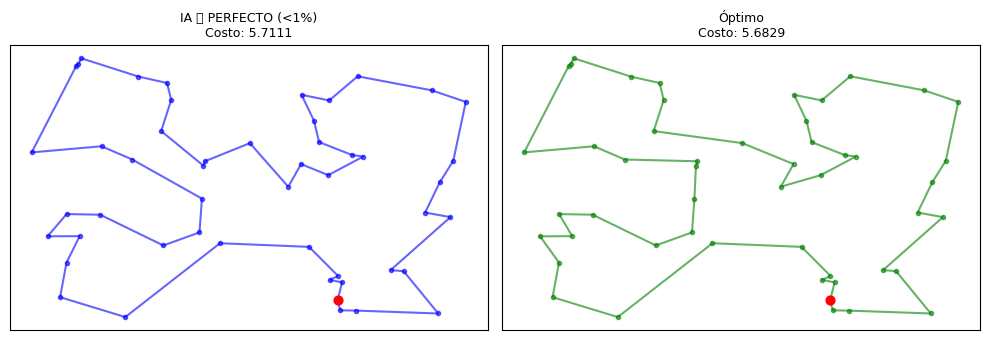

  6%|▌         | 115/2000 [00:04<01:07, 27.99it/s]

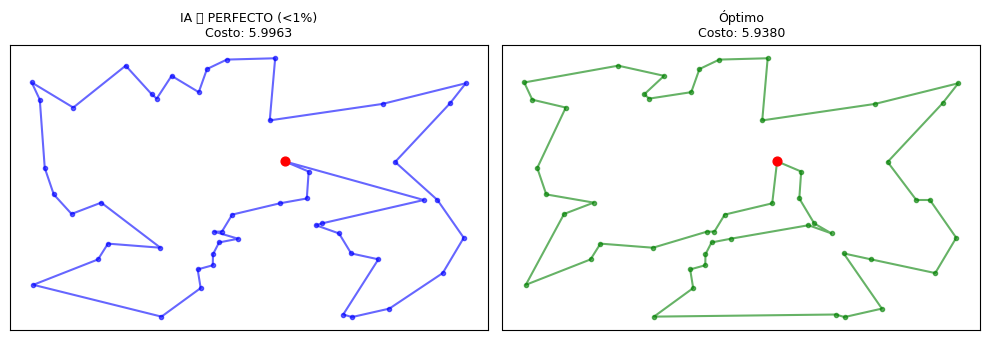

  6%|▌         | 118/2000 [00:04<01:17, 24.21it/s]

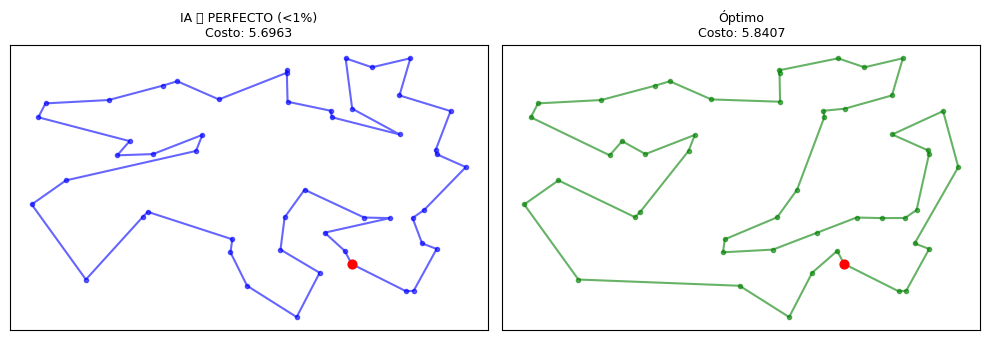

  7%|▋         | 140/2000 [00:05<01:11, 25.87it/s]

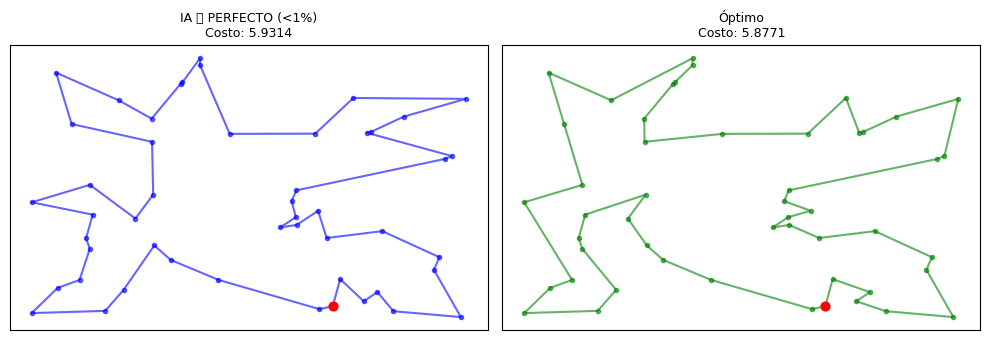

  8%|▊         | 150/2000 [00:06<01:11, 25.74it/s]

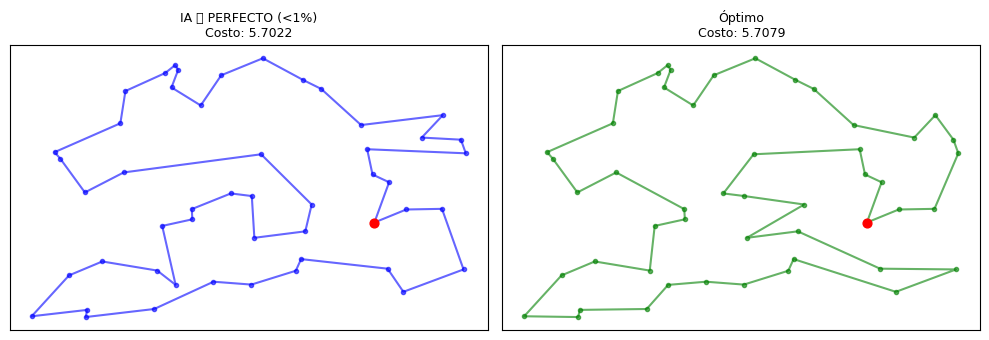

  8%|▊         | 158/2000 [00:06<01:10, 26.01it/s]

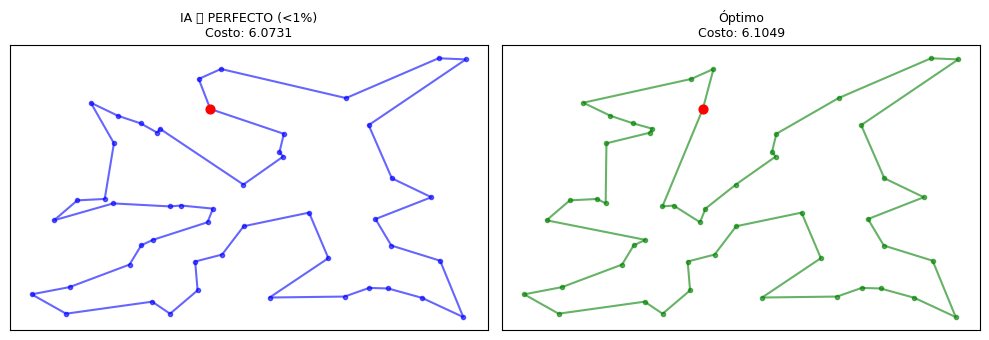

  8%|▊         | 165/2000 [00:06<01:07, 27.27it/s]

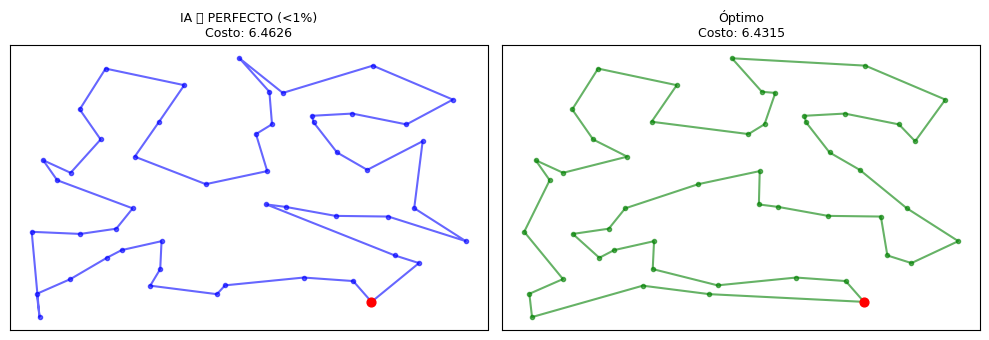

  9%|▉         | 177/2000 [00:07<01:10, 25.90it/s]

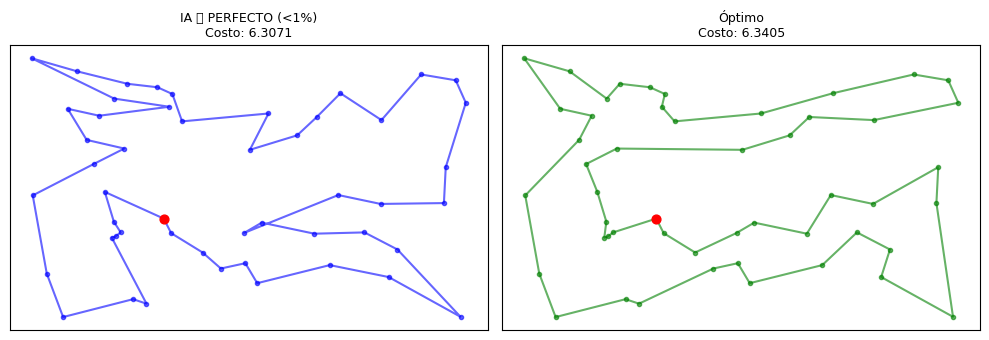

 10%|█         | 208/2000 [00:08<01:01, 29.36it/s]

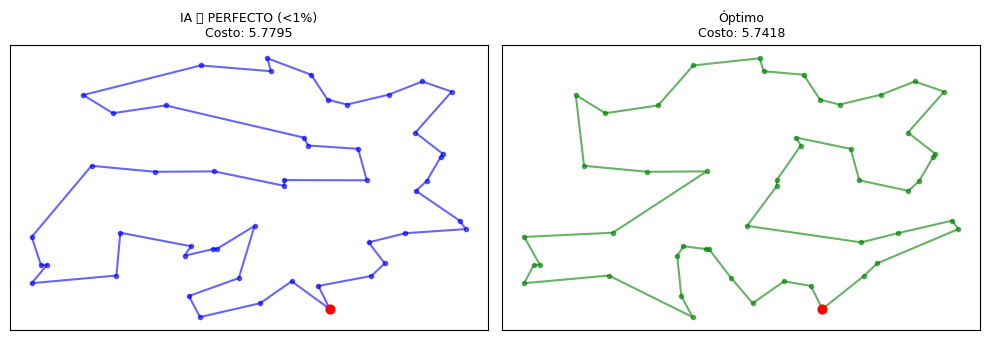

 11%|█         | 222/2000 [00:09<01:03, 28.17it/s]

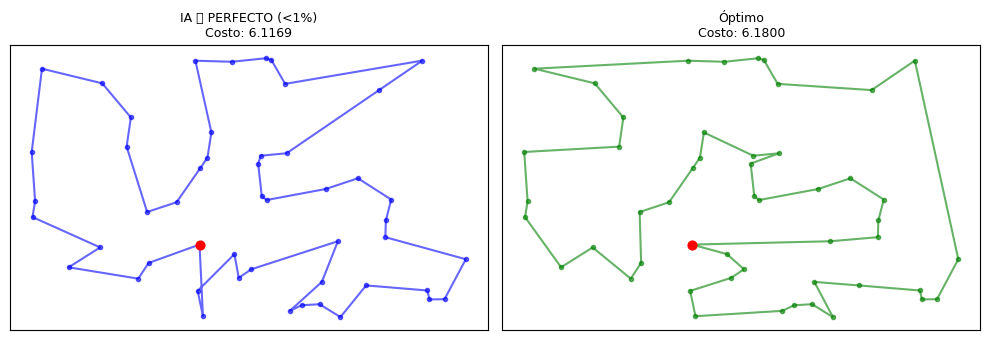

 11%|█▏        | 225/2000 [00:09<01:07, 26.14it/s]

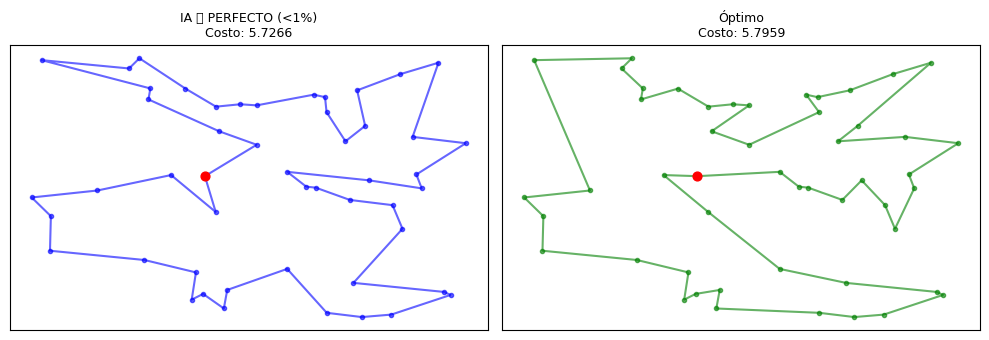

100%|██████████| 2000/2000 [01:09<00:00, 28.80it/s]


📊 RESULTADO FINAL (N=50):
   Gap Promedio: 6.82%
   Casos Perfectos (<1%): 165/2000 (8.2%)


In [74]:
import time
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- FUNCIONES AUXILIARES ---
def calculate_tour_length(dist_matrix, tour):
    cost = 0.0
    for i in range(len(tour) - 1):
        u, v = tour[i], tour[i+1]
        cost += dist_matrix[u][v]
    cost += dist_matrix[tour[-1]][tour[0]]
    return cost

def plot_tour(ax, points, tour, cost, title, color='b'):
    tour_closed = np.append(tour, tour[0])
    path = points[tour_closed]
    ax.plot(path[:, 0], path[:, 1], linestyle='-', marker='o', color=color, alpha=0.6, markersize=3)
    ax.scatter(path[0, 0], path[0, 1], c='red', s=40, zorder=10)
    ax.set_title(f"{title}\nCosto: {cost:.4f}", fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

# --- BEAM SEARCH VECTORIZADO ---
def solve_beam_batch(model, x, beam_width=3):
    model.eval()
    B, N, _ = x.shape

    # 1. Normalizar
    max_vals = x.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]
    x_norm = x / torch.max(max_vals, torch.tensor(1.0, device=DEVICE))

    # 2. Expandir
    x_expanded = x_norm.repeat_interleave(beam_width, dim=0)

    # 3. Inicializar
    tours = torch.zeros((B * beam_width, N), dtype=torch.long).to(DEVICE)
    visited = torch.full((B * beam_width, N), -1, dtype=torch.long).to(DEVICE)
    visited[:, 0] = 0

    beam_scores = torch.zeros((B, beam_width), device=DEVICE)
    beam_scores[:, 1:] = float('-inf')
    beam_scores = beam_scores.view(-1)

    mask = torch.zeros((B * beam_width, N), device=DEVICE)
    mask[:, 0] = float('-inf')

    batch_base_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE).unsqueeze(1)

    with torch.no_grad():
        for t in range(N - 1):
            logits = model(x_expanded, visited) + mask
            log_probs = F.log_softmax(logits, dim=1)

            curr_scores = beam_scores.unsqueeze(1) + log_probs
            curr_scores = curr_scores.view(B, beam_width * N)

            top_scores, top_indices = torch.topk(curr_scores, beam_width, dim=1)

            prev_beam_idx = top_indices // N
            next_city_idx = top_indices % N

            flat_prev_idx = (batch_base_indices + prev_beam_idx).view(-1)

            beam_scores = top_scores.view(-1)
            tours = tours[flat_prev_idx]
            visited = visited[flat_prev_idx]
            mask = mask[flat_prev_idx]

            next_cities_flat = next_city_idx.view(-1)
            tours[:, t+1] = next_cities_flat
            visited[:, t+1] = next_cities_flat
            mask.scatter_(1, next_cities_flat.unsqueeze(1), float('-inf'))

    best_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE)
    return tours[best_indices]

# --- EVALUACIÓN MEJORADA (MÁS PLOTS) ---
def evaluate_optimized(model, num_samples=100, num_cities=50, beam_width=3, batch_size=50):
    print(f"🚀 Generando {num_samples} casos (N={num_cities})...")

    # 1. Generar datos
    all_points = np.random.rand(num_samples, num_cities, 2)
    x_tensor = torch.tensor(all_points, dtype=torch.float32).to(DEVICE)

    # 2. Inferencia IA
    print(f"🧠 Ejecutando Beam Search (k={beam_width}) en GPU...")
    start_time = time.time()

    all_pred_tours = []
    for i in range(0, num_samples, batch_size):
        xb = x_tensor[i : i+batch_size]
        with torch.no_grad():
            tours_b = solve_beam_batch(model, xb, beam_width=beam_width)
        all_pred_tours.append(tours_b.cpu().numpy())

    ai_tours = np.concatenate(all_pred_tours, axis=0)
    ai_time = time.time() - start_time
    print(f"⚡ IA terminó en {ai_time:.2f}s")

    # 3. Comparación y Ploteo
    print(f"⏳ Evaluando resultados...")
    total_gap = 0.0
    perfect_count = 0
    plots_shown = 0
    MAX_PERFECT_PLOTS = 5 # Para no saturar el navegador si el modelo es muy bueno

    for i in tqdm(range(num_samples)):
        points = all_points[i]
        tour_ai = ai_tours[i]

        instance = TSP_Instance(points)
        cost_ai = calculate_tour_length(instance.distance_matrix, tour_ai)

        # OR-Tools
        tour_opt = solve_ortools(instance)
        cost_opt = calculate_tour_length(instance.distance_matrix, tour_opt)

        gap = ((cost_ai - cost_opt) / cost_opt) * 100
        total_gap += gap

        # LÓGICA DE VISUALIZACIÓN
        should_plot = False
        title_suffix = ""

        # Condición 1: Los primeros 3 casos siempre
        if i < 3:
            should_plot = True
            title_suffix = f"(Muestra {i+1})"

        # Condición 2: Si es casi perfecto (< 1%)
        elif gap < 1.0:
            perfect_count += 1
            if plots_shown < MAX_PERFECT_PLOTS + 3: # Limite de plots
                should_plot = True
                title_suffix = "🌟 PERFECTO (<1%)"

        if should_plot:
             fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
             plot_tour(axs[0], points, tour_ai, cost_ai, f"IA {title_suffix}", 'blue')
             plot_tour(axs[1], points, tour_opt, cost_opt, "Óptimo", 'green')
             plt.tight_layout()
             plt.show()
             plots_shown += 1

    print(f"\n📊 RESULTADO FINAL (N={num_cities}):")
    print(f"   Gap Promedio: {total_gap/num_samples:.2f}%")
    print(f"   Casos Perfectos (<1%): {perfect_count}/{num_samples} ({perfect_count/num_samples*100:.1f}%)")


# Cargar y Ejecutar
if 'trained_model' in globals():
    model_eval = trained_model
else:
    model_eval = TSPTransformer(num_layers=3, num_heads=8, embed_dim=128).to(DEVICE)
    model_eval.load_state_dict(torch.load("models/tsp_transformer.pth", map_location=DEVICE))

# Prueba con N=35
evaluate_optimized(model_eval, num_samples= 2000, num_cities=50, beam_width=3)

#VALIDACION CON LA DATA DE GIHUB


In [56]:
import os


# --- CONFIGURACIÓN ---
REPO_USER = "felipe-astudillo-s"
REPO_NAME = "TransformerTSP"
BRANCH = "main"

VAL_FOLDERS = {
    "EASY":   {"gh_path": "Data/Validation/Easy",   "prefix": "tsp_easy"},
    "MEDIUM": {"gh_path": "Data/Validation/Medium", "prefix": "tsp_medium"},
    "HARD":   {"gh_path": "Data/Validation/Hard",   "prefix": "tsp_hard"}
}

# Variable Global para almacenar datos en RAM
GLOBAL_DATA = {}

def download_and_load():
    print("📦 Iniciando descarga y carga de datos...")

    for phase, cfg in VAL_FOLDERS.items():
        print(f"   🔹 Cargando Fase: {phase}...")
        local_dir = f"val_data/{phase}"
        os.makedirs(local_dir, exist_ok=True)

        # 1. Obtener lista de archivos de GitHub API
        api_url = f"https://api.github.com/repos/{REPO_USER}/{REPO_NAME}/contents/{cfg['gh_path']}?ref={BRANCH}"
        try:
            resp = requests.get(api_url)
            if resp.status_code != 200:
                print(f"      ⚠️ Error accediendo a GitHub: {resp.status_code}"); continue
            files = resp.json()
        except: print("      ⚠️ Error de conexión."); continue

        # 2. Descargar y cargar en lista
        all_points, all_sols = [], []

        count = 0
        for item in files:
            if item['name'].endswith('.npz') and item['name'].startswith(cfg['prefix']):
                local_path = os.path.join(local_dir, item['name'])

                # Descargar si no existe
                if not os.path.exists(local_path):
                    with open(local_path, 'wb') as f:
                        f.write(requests.get(item['download_url']).content)

                # Cargar en memoria
                data = np.load(local_path, allow_pickle=True)
                pts = data['points'] # [B, N, 2]
                sols = data['solutions']

                # Uniformar formato de soluciones
                if sols.dtype == np.object_:
                    sols = np.vstack(sols).astype(np.int64)
                else:
                    sols = sols.astype(np.int64)

                # Padding standard a 100 para guardar en array uniforme
                B, N, _ = pts.shape
                pad = 100 - N
                if pad > 0:
                    pts = np.pad(pts, ((0,0), (0,pad), (0,0)), 'constant')
                    sols = np.pad(sols, ((0,0), (0,pad)), 'constant', constant_values=-1)

                all_points.append(pts)
                all_sols.append(sols)
                count += 1

        if all_points:
            GLOBAL_DATA[phase] = {
                'X': np.concatenate(all_points),
                'Y': np.concatenate(all_sols)
            }
            print(f"      ✅ {count} archivos cargados. Total casos: {len(GLOBAL_DATA[phase]['X'])}")
        else:
            print("      ⚠️ No se encontraron archivos .npz")

    print("\n✨ Carga completa. Datos listos en GLOBAL_DATA.")

# Ejecutar carga
download_and_load()

📦 Iniciando descarga y carga de datos...
   🔹 Cargando Fase: EASY...
      ✅ 10 archivos cargados. Total casos: 1000
   🔹 Cargando Fase: MEDIUM...
      ✅ 10 archivos cargados. Total casos: 1000
   🔹 Cargando Fase: HARD...
      ✅ 5 archivos cargados. Total casos: 500

✨ Carga completa. Datos listos en GLOBAL_DATA.


C:\Users\intix\AppData\Local\Temp\ipykernel_41856\4077115481.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=D

🚀 INICIANDO EVALUACIÓN RÁPIDA (Beam Width=3)

🔹 FASE: EASY
   ℹ️ Detectado N=20. Recortando tensores para velocidad y precisión.
   🧠 Inferencia en 1000 casos (Batch Size=128)...


100%|██████████| 8/8 [00:03<00:00,  2.63it/s]
C:\Users\intix\AppData\Local\Temp\ipykernel_41856\4077115481.py:197: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


   📊 GAP PROMEDIO: 5.02%
   🏆 Casos Perfectos: 176/1000 (17.6%)


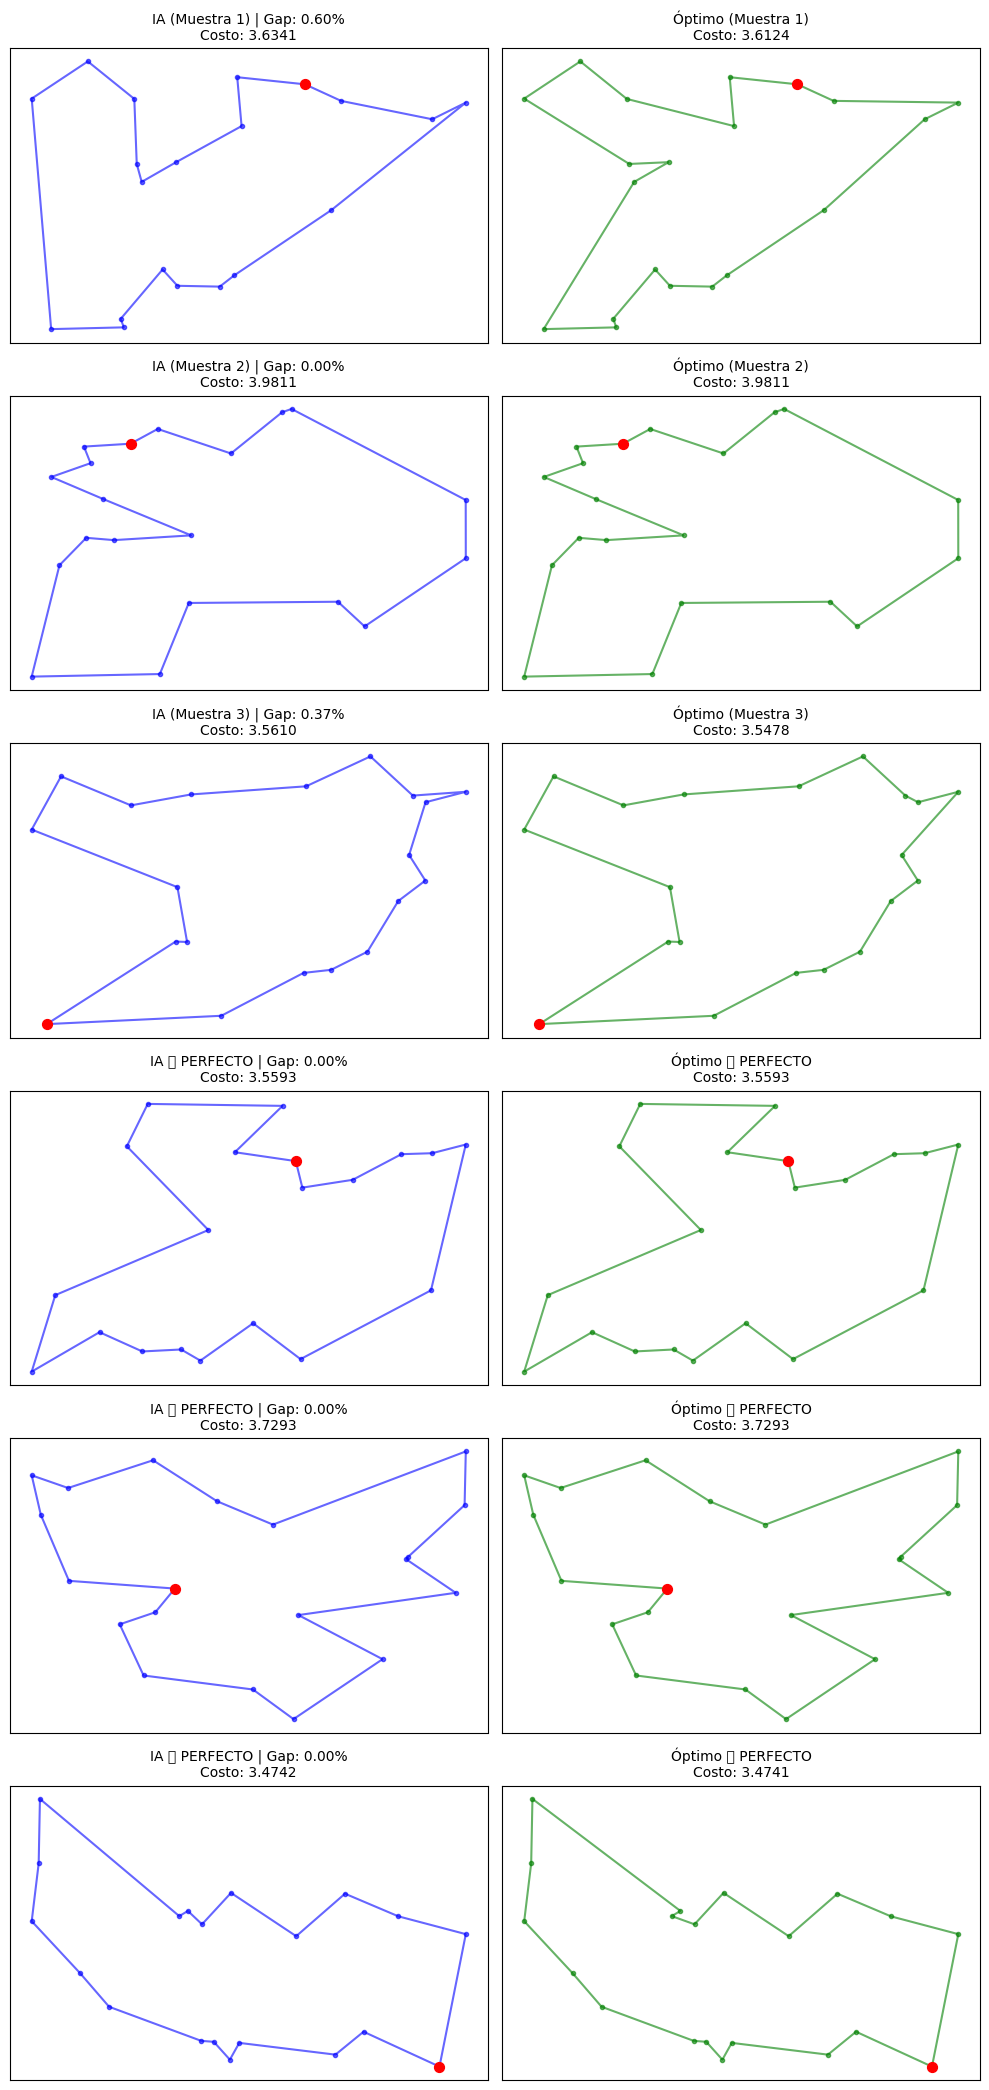


🔹 FASE: MEDIUM
   ℹ️ Detectado N=50. Recortando tensores para velocidad y precisión.
   🧠 Inferencia en 1000 casos (Batch Size=128)...


100%|██████████| 8/8 [00:14<00:00,  1.81s/it]


   📊 GAP PROMEDIO: 4.21%
   🏆 Casos Perfectos: 122/1000 (12.2%)


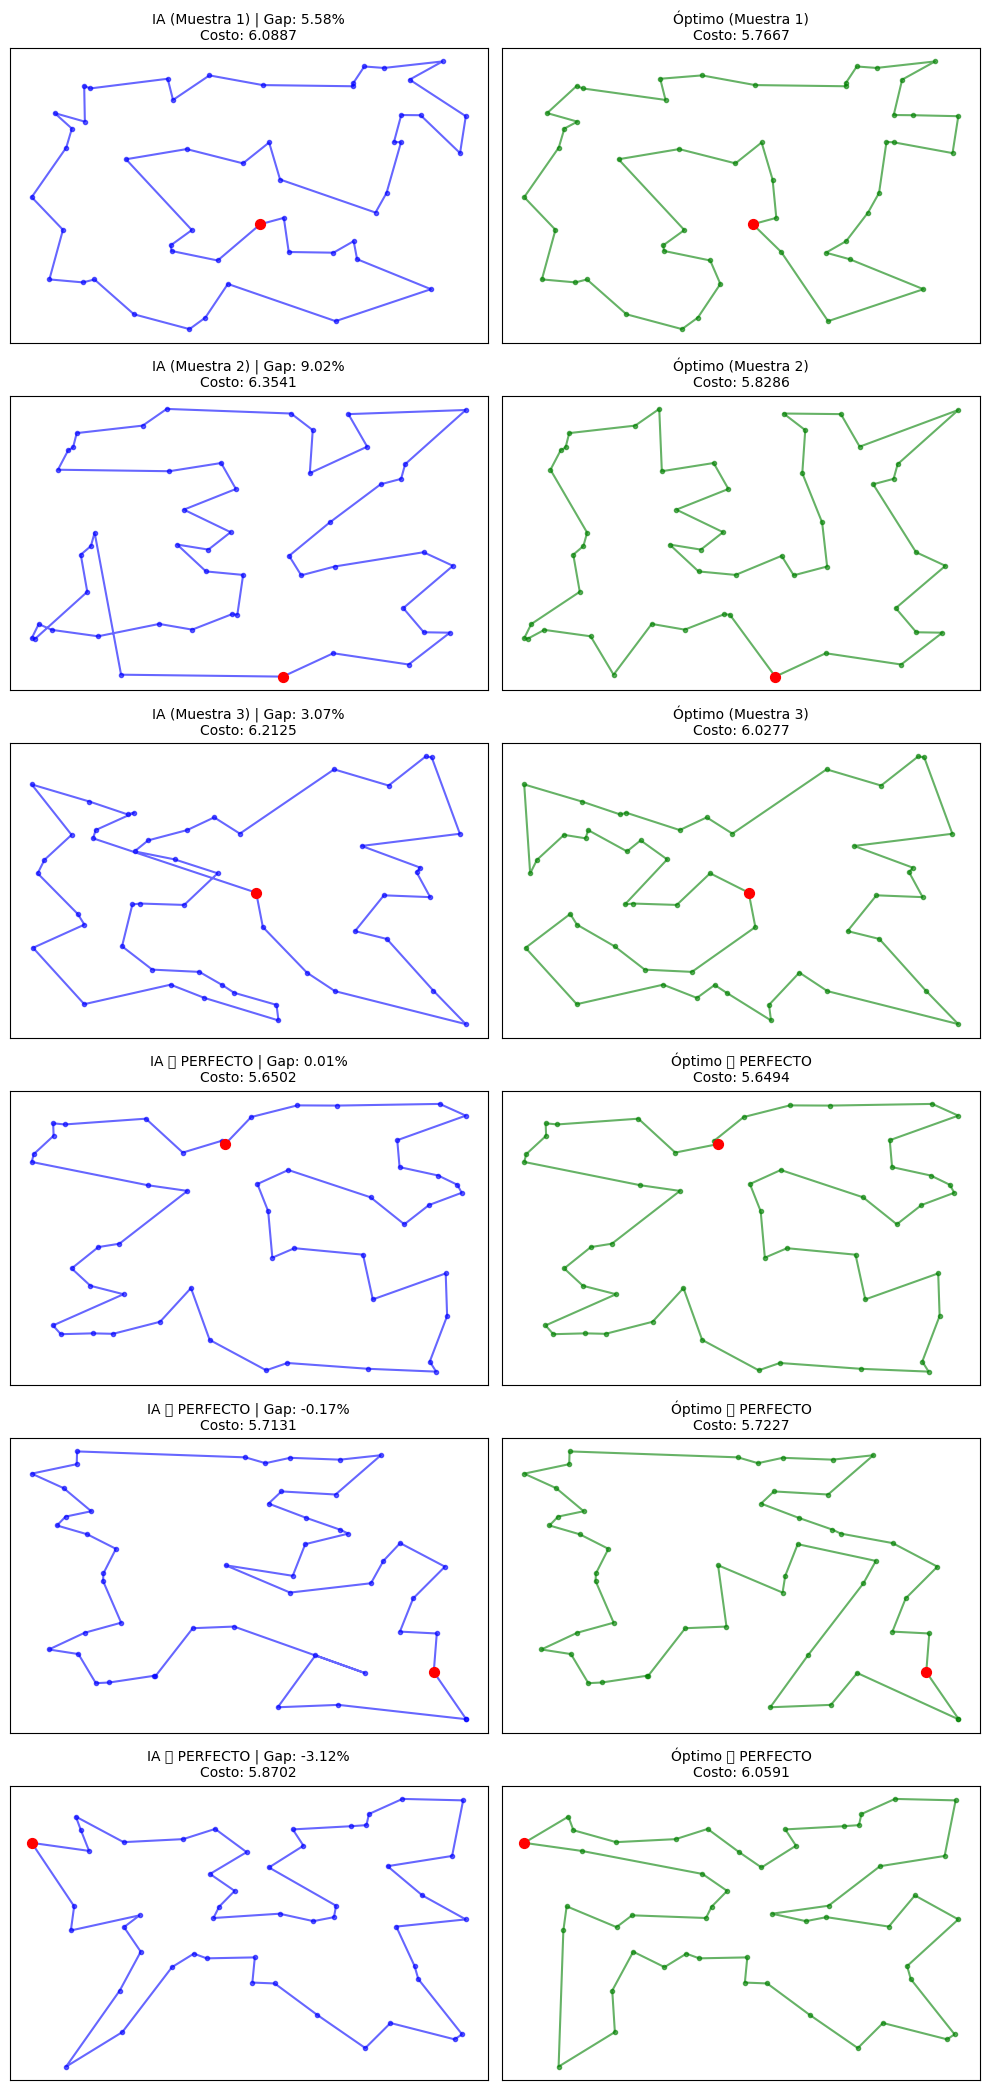


🔹 FASE: HARD
   ℹ️ Detectado N=100. Recortando tensores para velocidad y precisión.
   🧠 Inferencia en 500 casos (Batch Size=128)...


100%|██████████| 4/4 [02:25<00:00, 36.29s/it]


   📊 GAP PROMEDIO: 7.56%
   🏆 Casos Perfectos: 6/500 (1.2%)


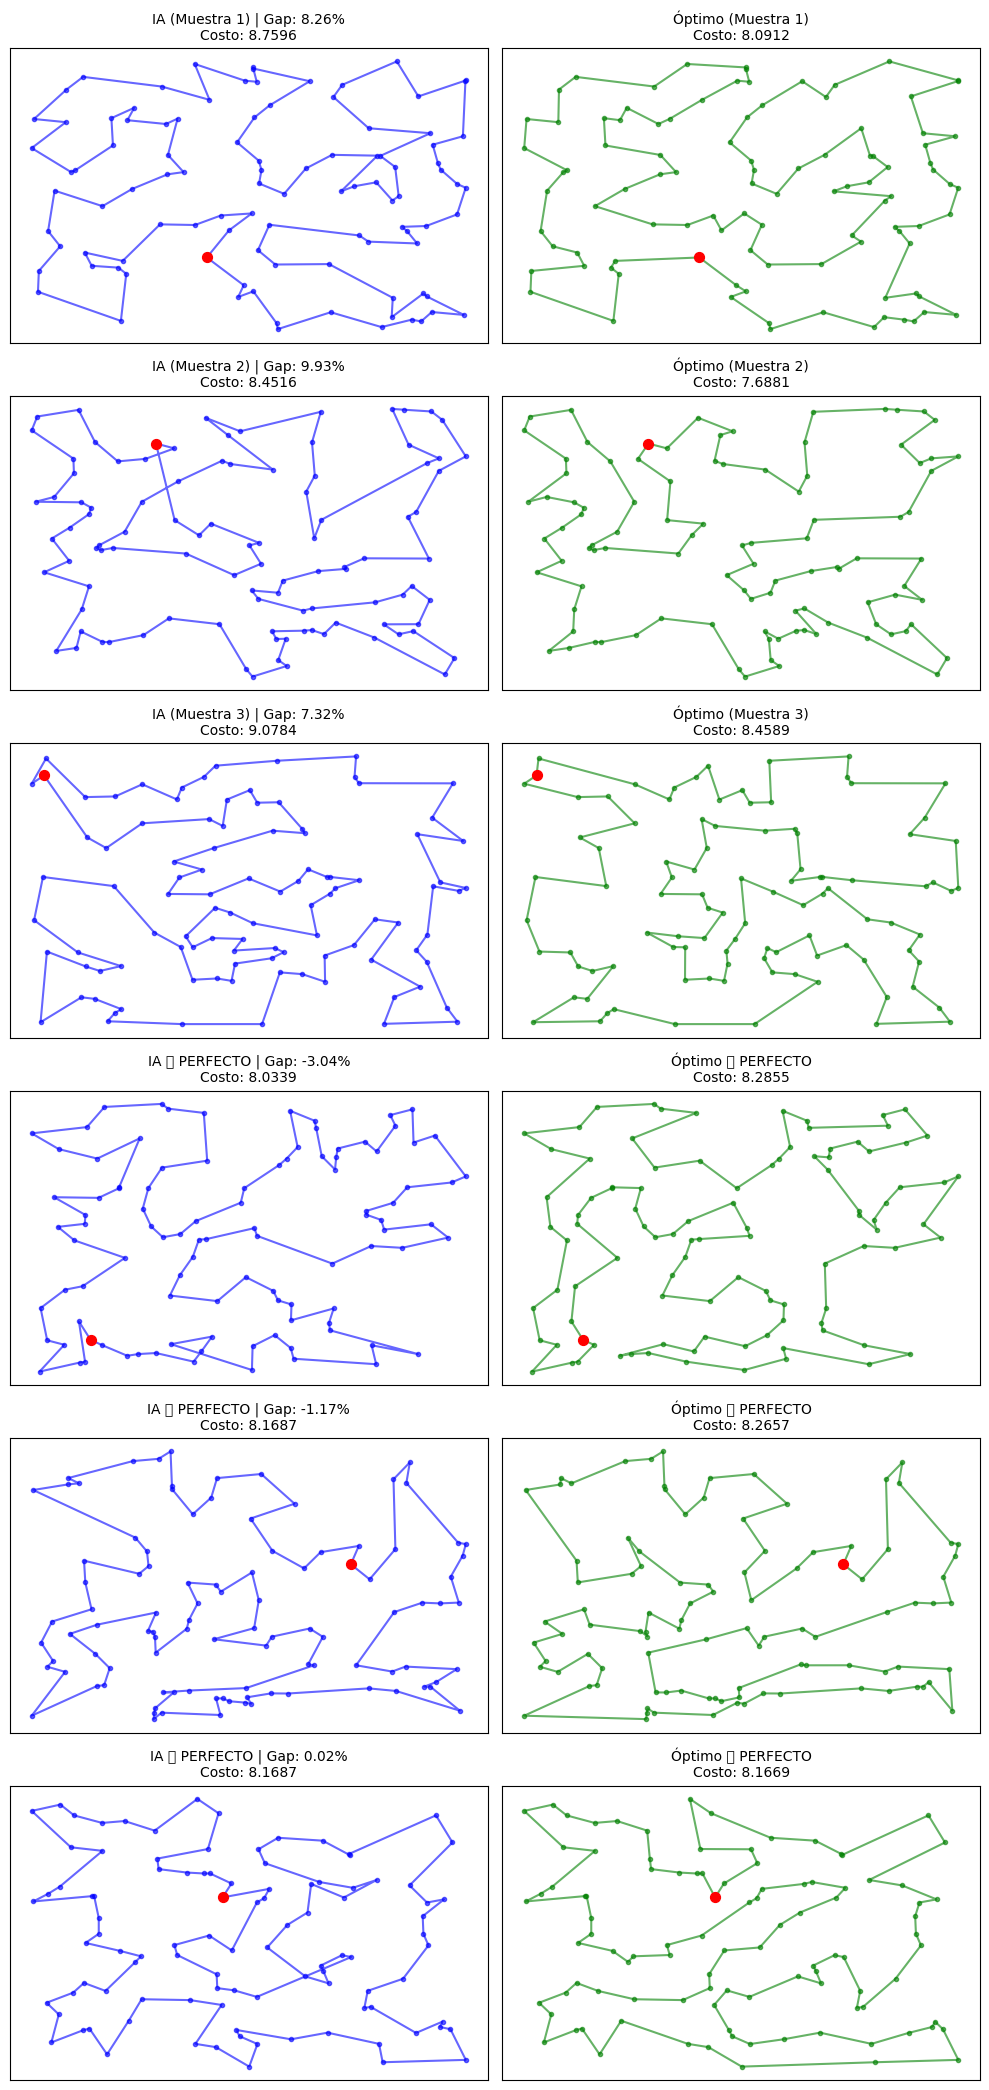

In [73]:


# --- CONFIGURACIÓN ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEAM_WIDTH = 3 
BATCH_SIZE = 128
MAX_PLOTS = 4

# --- BEAM SEARCH VECTORIZADO (El Rápido) ---
def solve_beam_batch(model, x, beam_width=3):
    """Procesa un batch entero [B, N, 2] simultáneamente."""
    model.eval()
    B, N, _ = x.shape

    # 1. Normalizar
    max_vals = x.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]
    x_norm = x / torch.max(max_vals, torch.tensor(1.0, device=DEVICE))

    # 2. Expandir
    x_expanded = x_norm.repeat_interleave(beam_width, dim=0)

    # 3. Inicializar
    tours = torch.zeros((B * beam_width, N), dtype=torch.long).to(DEVICE)
    visited = torch.full((B * beam_width, N), -1, dtype=torch.long).to(DEVICE)
    visited[:, 0] = 0

    beam_scores = torch.zeros((B, beam_width), device=DEVICE)
    beam_scores[:, 1:] = float('-inf')
    beam_scores = beam_scores.view(-1)

    mask = torch.zeros((B * beam_width, N), device=DEVICE)
    mask[:, 0] = float('-inf')

    batch_base_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE).unsqueeze(1)

    with torch.no_grad():
        for t in range(N - 1):
            logits = model(x_expanded, visited) + mask
            log_probs = F.log_softmax(logits, dim=1)

            curr_scores = beam_scores.unsqueeze(1) + log_probs
            curr_scores = curr_scores.view(B, beam_width * N)

            top_scores, top_indices = torch.topk(curr_scores, beam_width, dim=1)

            prev_beam_idx = top_indices // N
            next_city_idx = top_indices % N

            flat_prev_idx = (batch_base_indices + prev_beam_idx).view(-1)

            beam_scores = top_scores.view(-1)
            tours = tours[flat_prev_idx]
            visited = visited[flat_prev_idx]
            mask = mask[flat_prev_idx]

            next_cities_flat = next_city_idx.view(-1)
            tours[:, t+1] = next_cities_flat
            visited[:, t+1] = next_cities_flat
            mask.scatter_(1, next_cities_flat.unsqueeze(1), float('-inf'))

    best_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE)
    return tours[best_indices]

# --- DISTANCIA ---
def calc_dist(points, tour_idx):
    if points.device != tour_idx.device: tour_idx = tour_idx.to(points.device)
    valid_idx = tour_idx.clone()
    valid_idx[valid_idx == -1] = 0
    ordered = torch.gather(points, 1, valid_idx.unsqueeze(-1).expand(-1, -1, 2))
    diff = ordered - torch.roll(ordered, -1, dims=1)
    dist = torch.norm(diff, dim=2).sum(dim=1)
    return dist

# --- PLOT ---
def plot_val_case(ax, points, tour, cost, title, color):
    valid_tour = tour.tolist()
    if len(valid_tour) > 0: valid_tour.append(valid_tour[0])
    path = points[valid_tour]
    ax.plot(path[:,0], path[:,1], 'o-', color=color, alpha=0.6, markersize=3)
    ax.scatter(path[0,0], path[0,1], c='red', s=50, label='Start', zorder=10)
    ax.set_title(f"{title}\nCosto: {cost:.4f}", fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

# --- EJECUCIÓN RÁPIDA ---
def run_fast_evaluation():
    if not GLOBAL_DATA:
        print("❌ Primero ejecuta el Bloque 5-A para cargar los datos.")
        return

    # Cargar Modelo
    model_path = "models/tsp_transformer_ep60.pth"
    if not os.path.exists(model_path): model_path = "models/tsp_transformer.pth"
    model = TSPTransformer(num_layers=3, num_heads=8, embed_dim=128).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    print(f"🚀 INICIANDO EVALUACIÓN RÁPIDA (Beam Width={BEAM_WIDTH})")

    for phase, data in GLOBAL_DATA.items():
        print(f"\n{'='*60}")
        print(f"🔹 FASE: {phase}")

        X_all = data['X']
        Y_all = data['Y']

        # Detectar tamaño real N para hacer Slicing (Evitar el padding fantasma)
        # Miramos el primer ejemplo para ver hasta donde llegan los datos válidos
        # En GitHub Validation: Easy=20, Medium=50, Hard=100.
        sample_y = Y_all[0]
        n_real = np.sum(sample_y != -1)
        # Si por alguna razón falla la detección, fallback a shape
        if n_real < 5: n_real = X_all.shape[1]

        print(f"   ℹ️ Detectado N={n_real}. Recortando tensores para velocidad y precisión.")

        # Seleccionar muestras (ej: 1000)
        num_samples = min(1000, len(X_all))
        X_np = X_all[:num_samples, :n_real, :] # [1000, N_real, 2] <- SLICING CRÍTICO
        Y_np = Y_all[:num_samples, :n_real]    # [1000, N_real]

        # A Tensor
        if X_np.max() > 1.0: X_np /= X_np.max()
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

        # --- BUCLE BATCH (VELOCIDAD PURA) ---
        print(f"   🧠 Inferencia en {num_samples} casos (Batch Size={BATCH_SIZE})...")

        all_pred_tours = []
        for i in tqdm(range(0, num_samples, BATCH_SIZE)):
            xb = X_tensor[i : i+BATCH_SIZE]
            with torch.no_grad():
                # Aquí usamos la versión vectorizada rápida
                tour_b = solve_beam_batch(model, xb, beam_width=BEAM_WIDTH)
            all_pred_tours.append(tour_b)

        pred_tours = torch.cat(all_pred_tours, dim=0) # [Total, N]

        # --- MÉTRICAS ---
        dist_model = calc_dist(X_tensor, pred_tours)

        Y_tensor = torch.tensor(Y_np, dtype=torch.long).to(DEVICE)
        # El Y_np ya viene recortado, no tiene -1, pero por seguridad:
        Y_clean = Y_tensor.clone()
        Y_clean[Y_clean == -1] = 0
        dist_opt = calc_dist(X_tensor, Y_clean)

        # Gap
        # Evitar división por cero si dist_opt es 0 (caso trivial)
        mask_valid = dist_opt > 0
        gap = torch.zeros_like(dist_opt)
        gap[mask_valid] = ((dist_model[mask_valid] - dist_opt[mask_valid]) / dist_opt[mask_valid]) * 100

        avg_gap = gap.mean().item()

        # Conteo de perfectos (<0.05%)
        perfect_mask = gap < 0.05
        perfect_indices = torch.nonzero(perfect_mask).squeeze().cpu().numpy()
        if perfect_indices.ndim == 0 and perfect_indices.size == 1: perfect_indices = [perfect_indices.item()]
        elif perfect_indices.ndim == 0: perfect_indices = []

        num_perfect = len(perfect_indices)

        print(f"   📊 GAP PROMEDIO: {avg_gap:.2f}%")
        print(f"   🏆 Casos Perfectos: {num_perfect}/{num_samples} ({(num_perfect/num_samples)*100:.1f}%)")

        # --- VISUALIZACIÓN INTELIGENTE ---
        plots_data = []

        # 1. Agregar los primeros 3 fijos
        for i in range(min(3, num_samples)):
            plots_data.append({
                'idx': i, 'label': f"(Muestra {i+1})", 'gap': gap[i].item()
            })

        # 2. Agregar algunos perfectos (si no están ya en los primeros 3)
        added_perfects = 0
        for idx in perfect_indices:
            if idx >= 3 and added_perfects < 3: # Max 3 perfectos extra
                plots_data.append({
                    'idx': idx, 'label': "🌟 PERFECTO", 'gap': gap[idx].item()
                })
                added_perfects += 1

        # Graficar
        if plots_data:
            cols = 2
            rows = len(plots_data)
            fig, axs = plt.subplots(rows, 2, figsize=(10, 3.5 * rows))
            if rows == 1: axs = np.expand_dims(axs, 0)

            for k, item in enumerate(plots_data):
                idx = item['idx']
                cost_ai = dist_model[idx].item()
                cost_opt = dist_opt[idx].item()

                plot_val_case(axs[k, 0], X_np[idx], pred_tours[idx].cpu().numpy(), cost_ai, f"IA {item['label']} | Gap: {item['gap']:.2f}%", 'blue')
                plot_val_case(axs[k, 1], X_np[idx], Y_np[idx], cost_opt, f"Óptimo {item['label']}", 'green')

            plt.tight_layout()
            plt.show()

run_fast_evaluation()

C:\Users\intix\AppData\Local\Temp\ipykernel_41856\2221246533.py:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

📂 Modelo cargado: models/tsp_transformer.pth
🎲 INICIANDO EVALUACIÓN SAMPLING RÁPIDO
   - Samples por mapa: 50
   - Temperatura: 0.5

🔹 FASE: EASY
 🧠 Procesando 1000 mapas...


100%|██████████| 13/13 [00:01<00:00,  6.65it/s]
C:\Users\intix\AppData\Local\Temp\ipykernel_41856\2221246533.py:232: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()


 📊 GAP: 1.08% | 🏆 Perfectos: 470/1000


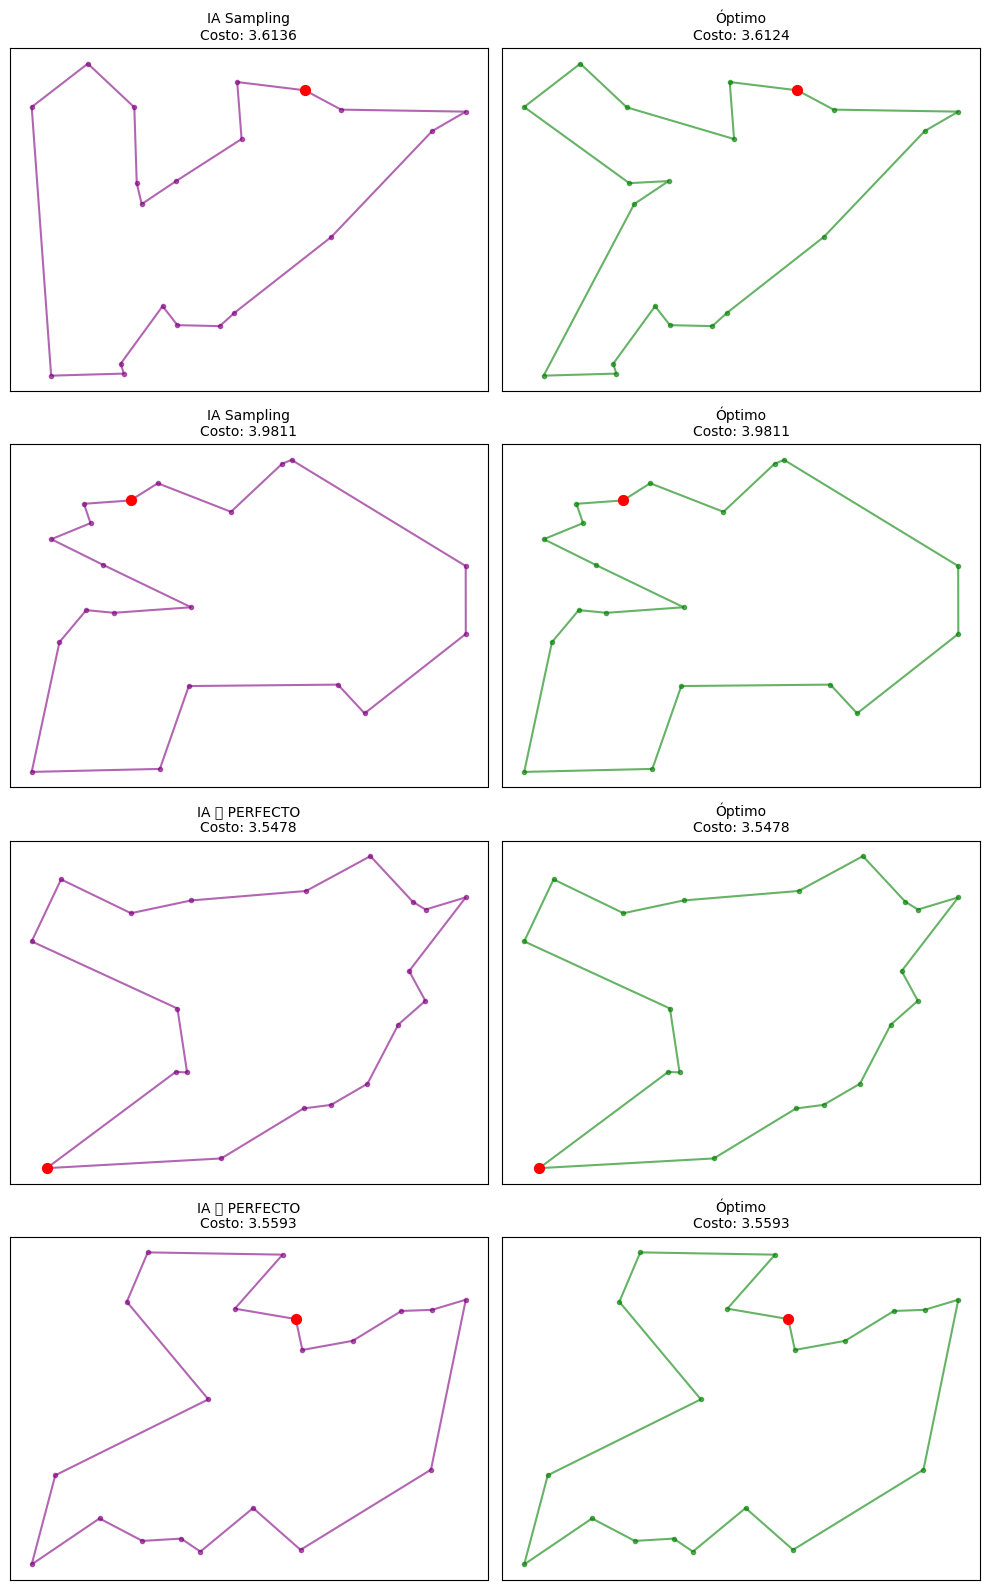


🔹 FASE: MEDIUM
 🧠 Procesando 1000 mapas...


100%|██████████| 13/13 [00:36<00:00,  2.77s/it]


 📊 GAP: 0.94% | 🏆 Perfectos: 283/1000


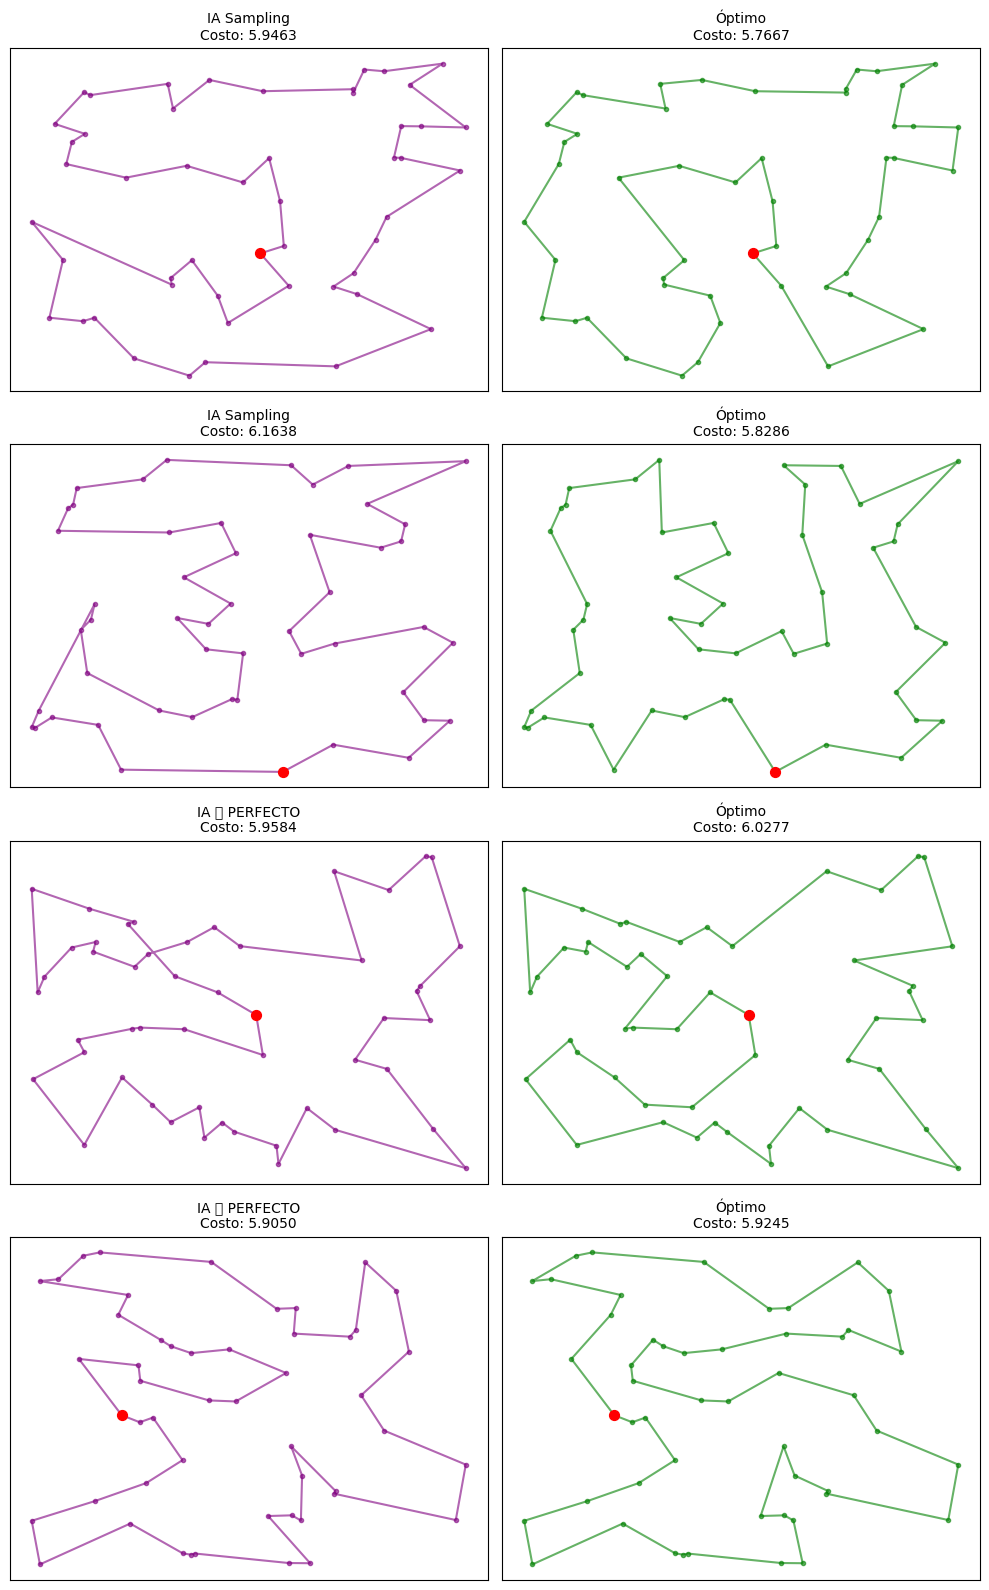


🔹 FASE: HARD
 🧠 Procesando 500 mapas...


100%|██████████| 7/7 [04:03<00:00, 34.78s/it]


 📊 GAP: 6.58% | 🏆 Perfectos: 4/500


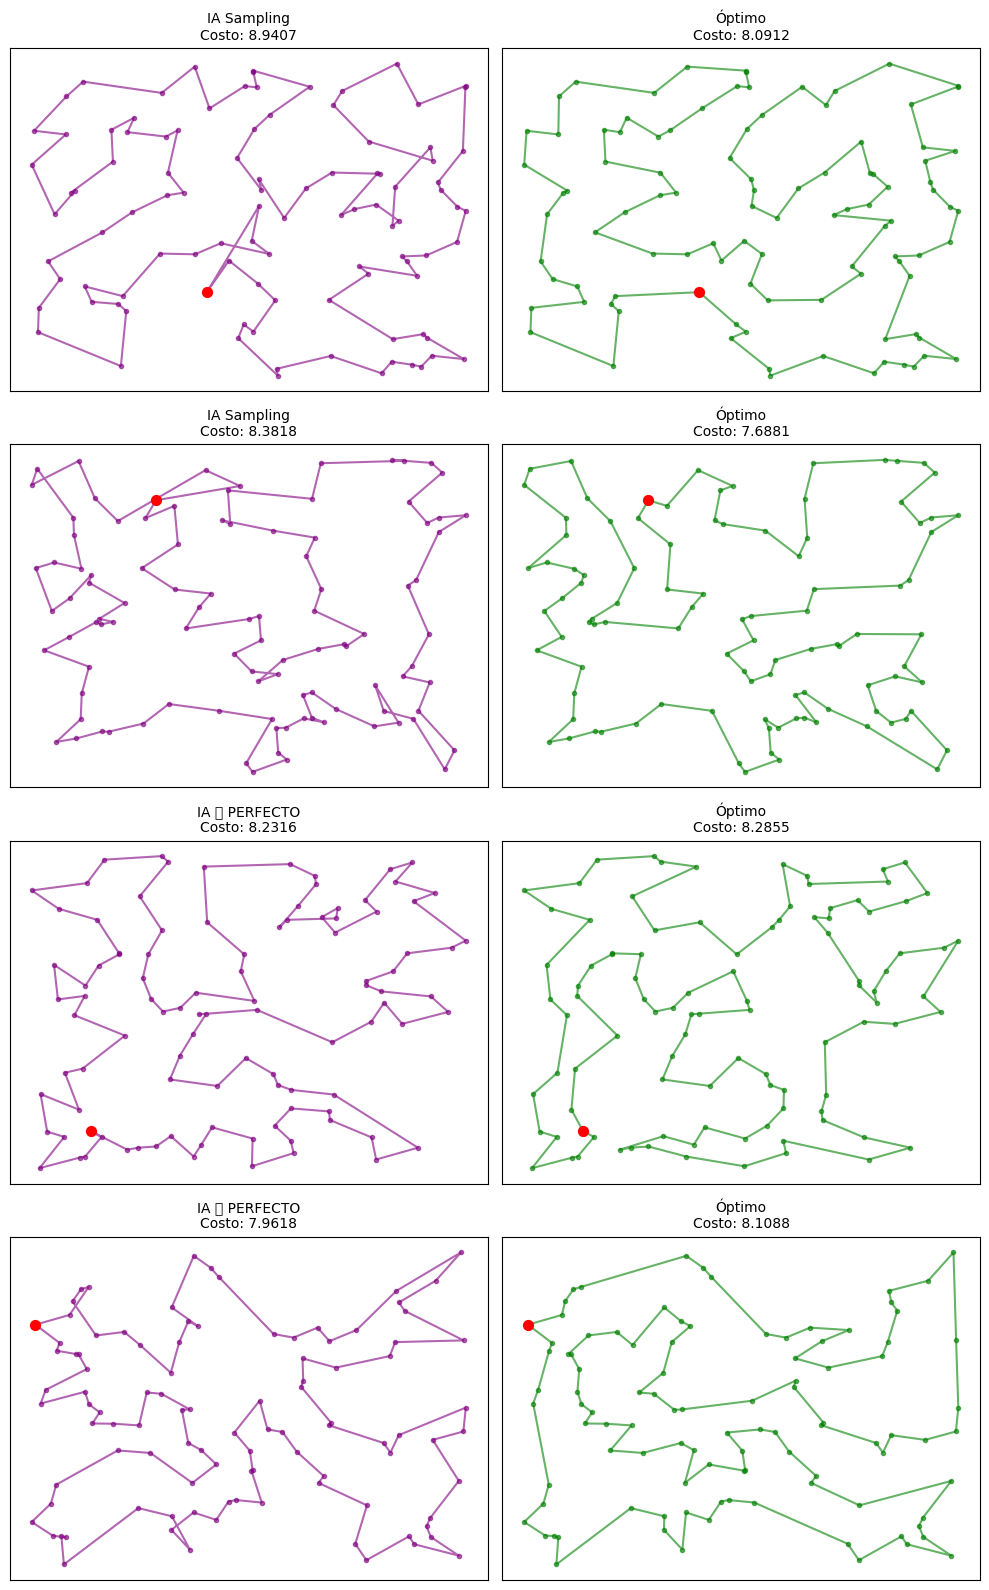

In [75]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# --- CONFIGURACIÓN DE SAMPLING ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128     # Tamaño del batch de mapas
NUM_SAMPLES = 50    # Intentos por mapa (Exploración)
TEMPERATURE = 0.5   # < 1.0 hace que el modelo sea más "seguro", > 1.0 más "loco"

# --- SOLVER SAMPLING VECTORIZADO & OPTIMIZADO (Encoder Caching) ---
def solve_sampling_batch_fast(model, x, num_samples=50, temp=1.0):
    """
    Versión OPTIMIZADA: Calcula el Encoder una vez y recicla la memoria.
    """
    model.eval()
    B, N, _ = x.shape
    
    # --- PASO 1: ENCODER (Solo una vez) ---
    # Normalizamos
    max_vals = x.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]
    x_norm = x / torch.max(max_vals, torch.tensor(1.0, device=DEVICE))
    
    with torch.no_grad():
        # Ejecutamos manualmente la parte del Encoder
        enc_input = model.encoder_input_layer(x_norm)
        memory_base = model.encoder(enc_input) # [B, N, Embed]

    # --- PASO 2: EXPANSIÓN (Para Sampling) ---
    # Repetimos la memoria 'num_samples' veces
    # memory shape: [B * num_samples, N, Embed]
    memory = memory_base.repeat_interleave(num_samples, dim=0)
    
    B_eff = B * num_samples # Batch efectivo total

    # Inicializar estado
    tours = torch.zeros((B_eff, N), dtype=torch.long).to(DEVICE)
    visited = torch.full((B_eff, N), -1, dtype=torch.long).to(DEVICE)
    visited[:, 0] = 0 # Start en nodo 0
    
    mask = torch.zeros((B_eff, N), device=DEVICE)
    mask[:, 0] = float('-inf')

    # Indices para vectorización
    batch_range = torch.arange(B_eff, device=DEVICE)

    # --- PASO 3: DECODER LOOP (Solo ejecutamos Decoder) ---
    with torch.no_grad():
        for t in range(N - 1):
            # --- Lógica Manual del Decoder (Para usar memoria pre-calculada) ---
            valid_mask = (visited != -1)
            
            # Crear máscara de visitados
            visited_city_mask = torch.zeros(B_eff, N, dtype=torch.bool, device=DEVICE)
            batch_idx = batch_range.unsqueeze(1).expand_as(visited)
            visited_city_mask[batch_idx[valid_mask], visited[valid_mask].long()] = True
            
            # Contexto: Promedio
            mask_expanded = visited_city_mask.unsqueeze(-1).float()
            sum_ctx = (memory * mask_expanded).sum(dim=1)
            count_ctx = mask_expanded.sum(dim=1).clamp(min=1)
            context_mean = sum_ctx / count_ctx
            
            # Contexto: Start + Last
            lengths = valid_mask.sum(dim=1) - 1
            start_node = visited[:, 0].long()
            last_node = visited.gather(1, lengths.unsqueeze(1).long()).squeeze(1).long()
            
            start_emb = memory[batch_range, start_node]
            last_emb = memory[batch_range, last_node]
            
            # Fusión y Atención
            ctx_concat = torch.cat([context_mean, last_emb, start_emb], dim=-1)
            query = model.ctx_fusion(ctx_concat).unsqueeze(1)
            
            # Cross Attention usando la MEMORIA CACHEADA
            attn_out, _ = model.cross_attn(query, memory, memory)
            ptr_query = model.pointer(attn_out.squeeze(1)).unsqueeze(1)
            scores = torch.matmul(ptr_query, memory.transpose(1, 2)).squeeze(1)
            logits = scores.masked_fill(visited_city_mask, float("-inf"))
            # -----------------------------------------------------------------

            # Aplicar Temperatura y Máscara acumulada
            logits = logits + mask
            logits = logits / temp
            probs = F.softmax(logits, dim=1) # [B_eff, N]
            
            # --- SAMPLING ---
            next_cities = torch.multinomial(probs, num_samples=1).squeeze(1) # [B_eff]
            
            # Actualizar
            tours[:, t+1] = next_cities
            visited[:, t+1] = next_cities
            mask.scatter_(1, next_cities.unsqueeze(1), float('-inf'))

    # --- PASO 4: SELECCIÓN DEL MEJOR ---
    # x_norm expandido solo para calcular distancias al final
    x_expand_calc = x_norm.repeat_interleave(num_samples, dim=0)
    all_dists = calc_dist(x_expand_calc, tours)
    
    # Reshape [B, Samples]
    all_dists = all_dists.view(B, num_samples)
    tours = tours.view(B, num_samples, N)
    
    # Argmin
    best_indices = torch.argmin(all_dists, dim=1) # [B]
    best_tours = tours[torch.arange(B), best_indices] # [B, N]
    
    return best_tours

# --- DISTANCIA ---
def calc_dist(points, tour_idx):
    if points.device != tour_idx.device: tour_idx = tour_idx.to(points.device)
    valid_idx = tour_idx.clone()
    valid_idx[valid_idx == -1] = 0
    ordered = torch.gather(points, 1, valid_idx.unsqueeze(-1).expand(-1, -1, 2))
    diff = ordered - torch.roll(ordered, -1, dims=1)
    dist = torch.norm(diff, dim=2).sum(dim=1)
    return dist

# --- PLOT ---
def plot_val_case(ax, points, tour, cost, title, color):
    valid_tour = tour.tolist()
    if len(valid_tour) > 0: valid_tour.append(valid_tour[0])
    path = points[valid_tour]
    ax.plot(path[:,0], path[:,1], 'o-', color=color, alpha=0.6, markersize=3)
    ax.scatter(path[0,0], path[0,1], c='red', s=50, label='Start', zorder=10)
    ax.set_title(f"{title}\nCosto: {cost:.4f}", fontsize=10)
    ax.set_xticks([]); ax.set_yticks([])

# --- EJECUCIÓN EVALUACIÓN ---
def run_fast_sampling():
    if not GLOBAL_DATA:
        print("❌ Primero ejecuta el Bloque 5-A para cargar los datos.")
        return

    # Cargar Modelo
    model_path = "models/tsp_transformer_ep60.pth"
    if not os.path.exists(model_path): model_path = "models/tsp_transformer.pth"
    
    model = TSPTransformer(num_layers=3, num_heads=8, embed_dim=128).to(DEVICE)
    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print(f"📂 Modelo cargado: {model_path}")
    except:
        print("⚠️ Usando pesos aleatorios.")

    model.eval()

    print(f"🎲 INICIANDO EVALUACIÓN SAMPLING RÁPIDO")
    print(f"   - Samples por mapa: {NUM_SAMPLES}")
    print(f"   - Temperatura: {TEMPERATURE}")

    for phase, data in GLOBAL_DATA.items():
        print(f"\n{'='*60}")
        print(f"🔹 FASE: {phase}")

        X_all = data['X']
        Y_all = data['Y']
        
        # Detectar N
        sample_y = Y_all[0]
        n_real = np.sum(sample_y != -1)
        if n_real < 5: n_real = X_all.shape[1]
        
        # Usar TODOS los datos (1000)
        num_eval = len(X_all)
        
        X_np = X_all[:num_eval, :n_real, :]
        Y_np = Y_all[:num_eval, :n_real]

        if X_np.max() > 1.0: X_np /= X_np.max()
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

        print(f" 🧠 Procesando {num_eval} mapas...")

        all_pred_tours = []
        
        # Batch Size seguro dinámico (evitar OOM)
        # Ajustamos para que quepan (Batch * Samples) en memoria
        safe_bs = max(1, 4096 // NUM_SAMPLES)
        
        for i in tqdm(range(0, num_eval, safe_bs)):
            xb = X_tensor[i : i+safe_bs]
            with torch.no_grad():
                tour_b = solve_sampling_batch_fast(model, xb, num_samples=NUM_SAMPLES, temp=TEMPERATURE)
            all_pred_tours.append(tour_b)

        pred_tours = torch.cat(all_pred_tours, dim=0)

        # Métricas
        dist_model = calc_dist(X_tensor, pred_tours)
        Y_tensor = torch.tensor(Y_np, dtype=torch.long).to(DEVICE)
        Y_clean = Y_tensor.clone(); Y_clean[Y_clean == -1] = 0
        dist_opt = calc_dist(X_tensor, Y_clean)

        mask_valid = dist_opt > 0
        gap = torch.zeros_like(dist_opt)
        gap[mask_valid] = ((dist_model[mask_valid] - dist_opt[mask_valid]) / dist_opt[mask_valid]) * 100
        avg_gap = gap.mean().item()
        
        perfect_mask = gap < 0.05
        perfect_indices = torch.nonzero(perfect_mask).squeeze().cpu().numpy()
        if perfect_indices.ndim == 0 and perfect_indices.size == 1: perfect_indices = [perfect_indices.item()]
        elif perfect_indices.ndim == 0: perfect_indices = []
        num_perfect = len(perfect_indices)

        print(f" 📊 GAP: {avg_gap:.2f}% | 🏆 Perfectos: {num_perfect}/{num_eval}")

        # Plots
        plots_data = []
        for i in range(min(2, num_eval)):
            plots_data.append({'idx': i, 'label': "Sampling", 'gap': gap[i].item()})
        
        added = 0
        for idx in perfect_indices:
            if idx >= 2 and added < 2:
                plots_data.append({'idx': idx, 'label': "🌟 PERFECTO", 'gap': gap[idx].item()})
                added += 1

        if plots_data:
            rows = len(plots_data)
            fig, axs = plt.subplots(rows, 2, figsize=(10, 4 * rows))
            if rows == 1: axs = np.expand_dims(axs, 0)
            for k, item in enumerate(plots_data):
                idx = item['idx']
                plot_val_case(axs[k, 0], X_np[idx], pred_tours[idx].cpu().numpy(), dist_model[idx].item(), f"IA {item['label']}", 'purple')
                plot_val_case(axs[k, 1], X_np[idx], Y_np[idx], dist_opt[idx].item(), f"Óptimo", 'green')
            plt.tight_layout(); plt.show()

run_fast_sampling()